# Connect Forest Management Model with Forest Carbon Budget Model (with calibration)

Optionally, uninstall the ws3 package and replace it with a pointer to this local clone of the GitHub repository code (useful if you want ot tweak the source code for whatever reason).

## Set up Modelling Environment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import ws3 Module from Local Server
import ws3
#Show Module Path
ws3.__path__

['/media/data/project/yyan/tmp/ws3/examples/ws3']

In [3]:
# Install ws3 Module from GitHub and Import it
# install_ws3 = True
# install_ws3_localeditable = None
# if install_ws3:
#     if install_ws3_localeditable: # clobber ws3 installation with local editable copy
#         %pip uninstall -y ws3
#         %pip install -e ..
#     else: # install dev_libcbm branch from ws3 GitHub repo
#         %pip install -U git+https://github.com/gparadis/ws3@dev_libcbm
#     import ws3
#     ws3.__path__

In [4]:
# Install libcbm Module from GitHub and Import it
install_libcbm = False
if install_libcbm:
    %pip install -U git+https://github.com/cat-cfs/libcbm_py.git@main
    import libcbm
    libcbm.__path__

## Create and Run `ForestModel` instance

In [5]:
# Install Pandas Library Version 2.0.3
%pip install pandas==2.0.3

Note: you may need to restart the kernel to use updated packages.


In [6]:
# Import Modules
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import ws3.forest, ws3.core
import time

In [7]:
#Start Calculating the Running Time
Start = time.time()

In [8]:
# Set Basic Parameters
base_year = 2020
horizon = 20
period_length = 10
max_age = 1000
tvy_name = 'totvol'

In [9]:
# Creat Forest Model Instance for Timber Supply Area 24
fm = ws3.forest.ForestModel(model_name='tsa24',
                            model_path='data/woodstock_model_files_tsa24',
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)
fm.import_landscape_section()
fm.import_areas_section()
fm.import_yields_section()
fm.import_actions_section()
fm.import_transitions_section()
fm.initialize_areas()
fm.add_null_action()
fm.reset_actions()

fm.grow()

In [10]:
# Import Modules
from util import compile_scenario, plot_scenario

(<Figure size 1200x400 with 5 Axes>,
 array([<Axes: title={'center': 'Harvested area (ha)'}>,
        <Axes: title={'center': 'Harvested volume (m3)'}>,
        <Axes: title={'center': 'Growing Stock (m3)'}>,
        <Axes: title={'center': 'Ecosystem C stock (tons)'}>,
        <Axes: title={'center': 'Total Carbon Emission (tons)'}>],
       dtype=object))

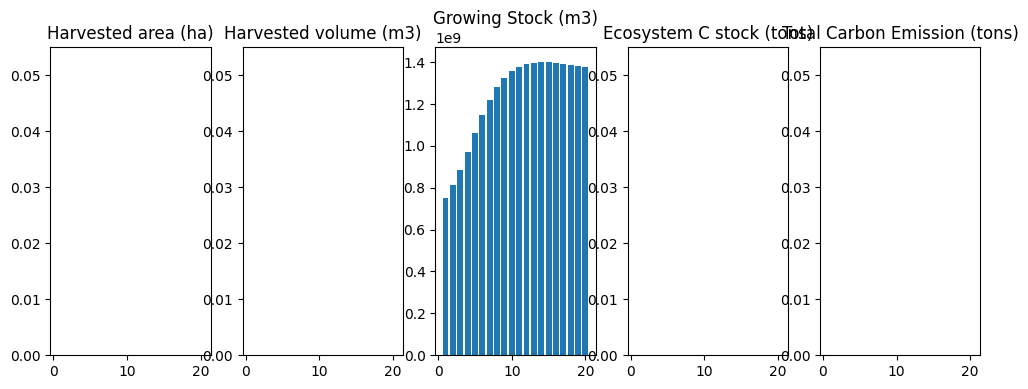

In [11]:
# Check the Forest Inventory of the Forest Model
df = compile_scenario(fm)
plot_scenario(df)

## Hard-link `ForestModel` to `libcbm`

In [12]:
# Import Modules
import libcbm
from util import run_cbm, cbm_report, plugin_c_curves, compare_ws3_cbm

Prepare CBM input files

In [13]:
# Define Disturance Types
disturbance_type_mapping = [{'user_dist_type': 'harvest', 'default_dist_type': 'Clearcut harvesting without salvage'},
                            {'user_dist_type': 'fire', 'default_dist_type': 'Wildfire'}]
for dtype_key in fm.dtypes:
    fm.dt(dtype_key).last_pass_disturbance = 'fire' if dtype_key[2] == dtype_key[4] else 'harvest'

In [14]:
# Define Sit_config File
sit_config = {
                'mapping_config': {
                    'nonforest': None,
                    'species': {
                        'species_classifier': 'species',
                        'species_mapping': [
                            {'user_species': 'softwood', 'default_species': 'Softwood forest type'},
                            {'user_species': 'hardwood', 'default_species': 'Hardwood forest type'}
                        ]
                    },
                    'spatial_units': {
                        'mapping_mode': 'SingleDefaultSpatialUnit',
                        'admin_boundary': 'British Columbia',
                        'eco_boundary': 'Montane Cordillera'},
                    'disturbance_types': {
                        'disturbance_type_mapping': disturbance_type_mapping
                    }
                }
            }

In [15]:
# Define Sit Files
sit_classifiers = pd.read_csv('data/libcbm_model_files_tsa24/sit_classifiers.csv')
sit_disturbance_types = pd.read_csv('data/libcbm_model_files_tsa24/sit_disturbance_types.csv')
sit_age_classes = pd.read_csv('data/libcbm_model_files_tsa24/sit_age_classes.csv')
sit_inventory = pd.read_csv('data/libcbm_model_files_tsa24/sit_inventory.csv')
sit_yield = pd.read_csv('data/libcbm_model_files_tsa24/sit_yield.csv')
sit_events = pd.read_csv('data/libcbm_model_files_tsa24/sit_events.csv')
sit_transitions = pd.read_csv('data/libcbm_model_files_tsa24/sit_transitions.csv')

In [16]:
# Define Sit Tables
sit_tables = {'sit_classifiers': sit_classifiers,
              'sit_disturbance_types': sit_disturbance_types,
              'sit_age_classes': sit_age_classes,
              'sit_inventory': sit_inventory,
              'sit_yield': sit_yield,
              'sit_events': sit_events,
              'sit_transitions': sit_transitions}

Here are other two ways to generate sit tables. But they are only suitbale for small forest model since they take too much running time and memory

In [17]:
# self = fm
# sit_tables = {'sit_classifiers':self._cbm_sit_classifiers(),
#               'sit_disturbance_types':self._cbm_sit_disturbance_types(),
#               'sit_age_classes':self._cbm_sit_age_classes(),
#               'sit_inventory':self._cbm_sit_inventory(softwood_volume_yname='swdvol', 
#                                                       hardwood_volume_yname='hwdvol'),
#               'sit_yield':self._cbm_sit_yield(softwood_volume_yname='swdvol', 
#                                               hardwood_volume_yname='hwdvol', n_yield_vals=100),
#               'sit_events':self._cbm_sit_events(),
#               'sit_transitions':self._cbm_sit_transitions()}

In [18]:
# self = fm
# sit_config, sit_tables = self.to_cbm_sit(softwood_volume_yname='swdvol', 
#                                          hardwood_volume_yname='hwdvol', 
#                                          admin_boundary='British Columbia', 
#                                          eco_boundary='Montane Cordillera',
#                                          disturbance_type_mapping=disturbance_type_mapping)

In [19]:
# Define Time Steps
n_steps = fm.horizon * fm.period_length

# Run CBM and Generate CBM 0utputs
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

Emissions from all biomass components only resulting from fire disturbance, while these from all DOM pools resulting from annual decay processes and fire disturbance.

In [20]:
# Define Carbon Pools
biomass_pools = ['SoftwoodMerch','SoftwoodFoliage', 'SoftwoodOther', 'SoftwoodCoarseRoots','SoftwoodFineRoots',                        
                 'HardwoodMerch', 'HardwoodFoliage', 'HardwoodOther', 'HardwoodCoarseRoots', 'HardwoodFineRoots']
dom_pools = ['AboveGroundVeryFastSoil', 'BelowGroundVeryFastSoil', 'AboveGroundFastSoil', 'BelowGroundFastSoil',
             'MediumSoil', 'AboveGroundSlowSoil', 'BelowGroundSlowSoil', 'SoftwoodStemSnag', 'SoftwoodBranchSnag',
             'HardwoodStemSnag', 'HardwoodBranchSnag']
emissions_pools = ['CO2', 'CH4', 'CO', 'NO2']
products_pools = ['Products']
ecosystem_pools = biomass_pools + dom_pools
all_pools = biomass_pools + dom_pools + emissions_pools + products_pools

In [21]:
# Define Carbon Fluxes
annual_process_fluxes = [
    'DecayDOMCO2Emission',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

npp_fluxes=[
    'DeltaBiomass_AG', 
    'DeltaBiomass_BG'
]
decay_emissions_fluxes = [
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

disturbance_production_fluxes = [
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction'   
]

disturbance_emissions_fluxes = [
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'   
]

all_fluxes = [
    'DisturbanceCO2Production',
    'DisturbanceCH4Production',
    'DisturbanceCOProduction',
    'DisturbanceBioCO2Emission',
    'DisturbanceBioCH4Emission',
    'DisturbanceBioCOEmission',
    'DecayDOMCO2Emission',
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir',
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceDOMCO2Emission',
    'DisturbanceDOMCH4Emission',
    'DisturbanceDOMCOEmission',
    'DisturbanceMerchLitterInput',
    'DisturbanceFolLitterInput',
    'DisturbanceOthLitterInput',
    'DisturbanceCoarseLitterInput',
    'DisturbanceFineLitterInput',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'
]

GrossGrowth_AG = flux[[
        "DeltaBiomass_AG",
        "TurnoverMerchLitterInput",
        "TurnoverFolLitterInput",
        "TurnoverOthLitterInput",
        ]].sum(axis=1)

GrossGrowth_BG = flux[[
        "DeltaBiomass_BG",
        "TurnoverCoarseLitterInput",
        "TurnoverFineLitterInput",
        ]].sum(axis=1)

In [22]:
# Define Sum Carbon Pools and Sum Carbon Fluxes
pools = ecosystem_pools
fluxes = decay_emissions_fluxes + disturbance_emissions_fluxes

sum_pools = ['ecosystem', 'biomass', 'DOM']

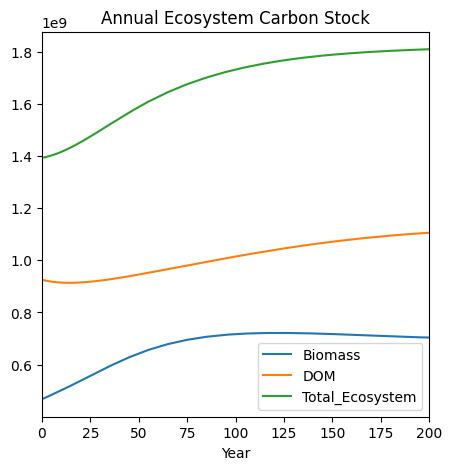

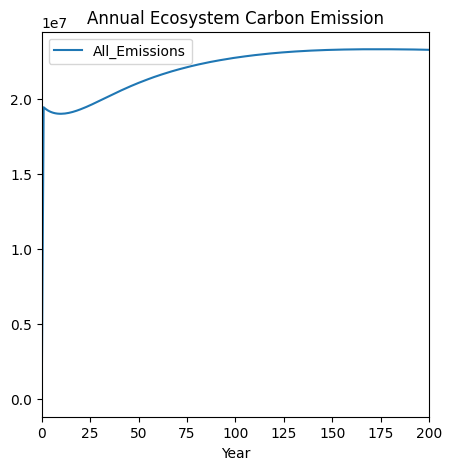

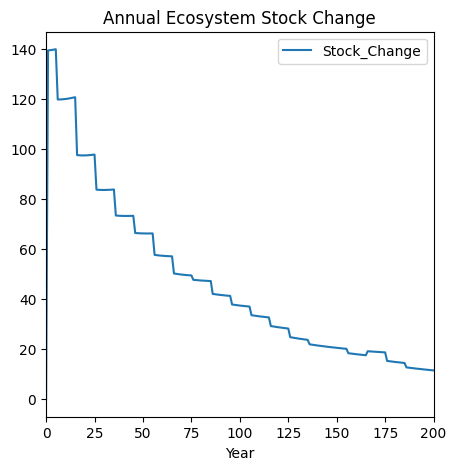

In [23]:
# Report Annual CBM Results
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes)

## Generate and Add Carbon Yield Curves

Carbon in product pools is considered a 100% immediate emission after harvesting activities.

Rebuild the inventory table. Set age to 0 and area to 1.0 ha.

The `sit_events` table should be empty.

In [24]:
sit_events

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,min_softwood_age,max_softwood_age,min_hardwood_age,...,MinSWMerchStemSnagC,MaxSWMerchStemSnagC,MinHWMerchStemSnagC,MaxHWMerchStemSnagC,efficiency,sort_type,target_type,target,disturbance_type,disturbance_year


In [25]:
sit_inventory

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,age,area,delay,landclass,historic_disturbance,last_pass_disturbance
0,tsa24,0,2401000,100,2401000,softwood,False,5,345.7,0,0,fire,fire
1,tsa24,0,2401000,100,2401000,softwood,False,15,825.8,0,0,fire,fire
2,tsa24,0,2401000,100,2401000,softwood,False,25,1611.1,0,0,fire,fire
3,tsa24,0,2401000,100,2401000,softwood,False,35,1508.5,0,0,fire,fire
4,tsa24,0,2401000,100,2401000,softwood,False,45,264.0,0,0,fire,fire
...,...,...,...,...,...,...,...,...,...,...,...,...,...
765,tsa24,1,2403007,100,2423007,softwood,False,25,7712.3,0,0,fire,harvest
766,tsa24,1,2403007,100,2423007,softwood,False,35,15703.9,0,0,fire,harvest
767,tsa24,1,2403007,100,2423007,softwood,False,45,11587.8,0,0,fire,harvest
768,tsa24,1,2403007,100,2423007,softwood,False,55,6871.6,0,0,fire,harvest


In [26]:
# Set Age and Area to 0 and 1.0
df = sit_inventory
df['age'] = df['age'].apply(lambda x: 0)
df['area'] = df['area'].apply(lambda x: 1.0)
df = df.drop_duplicates(ignore_index=True)

In [27]:
df

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,age,area,delay,landclass,historic_disturbance,last_pass_disturbance
0,tsa24,0,2401000,100,2401000,softwood,False,0,1.0,0,0,fire,fire
1,tsa24,0,2401001,304,2401001,softwood,False,0,1.0,0,0,fire,fire
2,tsa24,0,2401003,304,2401003,softwood,False,0,1.0,0,0,fire,fire
3,tsa24,0,2401004,104,2401004,softwood,False,0,1.0,0,0,fire,fire
4,tsa24,0,2401005,1201,2401005,hardwood,False,0,1.0,0,0,fire,fire
5,tsa24,0,2401006,1201,2401006,hardwood,False,0,1.0,0,0,fire,fire
6,tsa24,0,2402001,304,2402001,softwood,False,0,1.0,0,0,fire,fire
7,tsa24,0,2402005,1201,2402005,hardwood,False,0,1.0,0,0,fire,fire
8,tsa24,0,2402006,1201,2402006,hardwood,False,0,1.0,0,0,fire,fire
9,tsa24,0,2403005,1201,2403005,hardwood,False,0,1.0,0,0,fire,fire


Use the following code if any of the developments have no harvesting circumstances.

In [28]:
# df_sub = df.loc[(df['theme1'] == 1) & (df['last_pass_disturbance'] == 'fire')]
# df_sub['theme4'] = df_sub['theme4'].apply(lambda x: x + 20000)
# df_sub['last_pass_disturbance'] = df_sub['last_pass_disturbance'].apply(lambda x: 'harvest')
# df_sub
# df = pd.concat([df, df_sub], ignore_index=True)
# df = df.drop_duplicates(ignore_index=True)
# df

In [29]:
# Replace the Sit Inventory File in the Sit Table
sit_tables['sit_inventory'] = df

In [30]:
# Run CBM and Generate CBM 0utputs
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

In [31]:
# Generate Carbon Pool and Flux Indicators
pi = cbm_output.classifiers.to_pandas().merge(cbm_output.pools.to_pandas(), 
                                              left_on=["identifier", "timestep"], 
                                              right_on=["identifier", "timestep"])
fi = cbm_output.classifiers.to_pandas().merge(cbm_output.flux.to_pandas(), 
                                              left_on=["identifier", "timestep"], 
                                              right_on=["identifier", "timestep"])

In [32]:
pi

,identifier,timestep,theme0,theme1,theme2,theme3,theme4,species,Input,SoftwoodMerch,...,BelowGroundSlowSoil,SoftwoodStemSnag,SoftwoodBranchSnag,HardwoodStemSnag,HardwoodBranchSnag,CO2,CH4,CO,NO2,Products
0,1,0,tsa24,0,2401000,100,2401000,softwood,1.0,0.000000,...,74.016010,52.671391,23.112688,0.000000,0.000000,5878.431742,6.068142,54.611643,0.0,0.000000
1,2,0,tsa24,0,2401001,304,2401001,softwood,1.0,0.000000,...,44.921289,27.501144,19.287436,0.000000,0.000000,3613.528216,4.476831,40.290231,0.0,0.000000
2,3,0,tsa24,0,2401003,304,2401003,softwood,1.0,0.000000,...,70.049220,62.438897,24.551759,0.000000,0.000000,5650.351208,6.311380,56.800795,0.0,0.000000
3,4,0,tsa24,0,2401004,104,2401004,softwood,1.0,0.000000,...,53.956053,44.779207,21.934440,0.000000,0.000000,4365.512943,5.270469,47.432810,0.0,0.000000
4,5,0,tsa24,0,2401005,1201,2401005,hardwood,1.0,0.000000,...,127.289305,0.000000,0.000000,102.657634,21.803018,10841.470933,9.787445,88.084688,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7432,33,200,tsa24,1,2403003,304,2423003,softwood,1.0,95.609403,...,94.058717,9.559927,2.290215,0.000000,0.000000,7339.963239,6.855230,61.695426,0.0,72.563607
7433,34,200,tsa24,1,2403004,104,2403004,softwood,1.0,62.438897,...,73.407698,6.163382,1.917804,0.000000,0.000000,6049.629521,5.988370,53.893744,0.0,0.000000
7434,35,200,tsa24,1,2403004,104,2423004,softwood,1.0,75.781025,...,74.672467,7.263171,2.059984,0.000000,0.000000,5721.036242,5.630286,50.671138,0.0,51.700860
7435,36,200,tsa24,1,2403007,100,2403007,softwood,1.0,84.785477,...,107.130573,11.198718,2.231945,0.000000,0.000000,9047.847670,8.065668,72.589057,0.0,0.000000


In [33]:
fi

,identifier,timestep,theme0,theme1,theme2,theme3,theme4,species,DisturbanceCO2Production,DisturbanceCH4Production,...,DisturbanceVFastBGToAir,DisturbanceFastAGToAir,DisturbanceFastBGToAir,DisturbanceMediumToAir,DisturbanceSlowAGToAir,DisturbanceSlowBGToAir,DisturbanceSWStemSnagToAir,DisturbanceSWBranchSnagToAir,DisturbanceHWStemSnagToAir,DisturbanceHWBranchSnagToAir
0,1,0,tsa24,0,2401000,100,2401000,softwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0,tsa24,0,2401001,304,2401001,softwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0,tsa24,0,2401003,304,2401003,softwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0,tsa24,0,2401004,104,2401004,softwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0,tsa24,0,2401005,1201,2401005,hardwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7432,33,200,tsa24,1,2403003,304,2423003,softwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7433,34,200,tsa24,1,2403004,104,2403004,softwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7434,35,200,tsa24,1,2403004,104,2423004,softwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7435,36,200,tsa24,1,2403007,100,2403007,softwood,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
# Define Development Type Keys
pi['dtype_key'] = pi.apply(lambda r: '%s %s %s %s %s' % (r['theme0'], r['theme1'], r['theme2'], r['theme3'], r['theme4']), axis=1)
fi['dtype_key'] = fi.apply(lambda r: '%s %s %s %s %s' % (r['theme0'], r['theme1'], r['theme2'], r['theme3'], r['theme4']), axis=1)

In [35]:
# Generate Carbon Pool anf Flux Curves
c_curves_p = pi.groupby(['dtype_key', 'timestep'], as_index=True)[all_pools].sum()
c_curves_f = fi.groupby(['dtype_key', 'timestep'], as_index=True)[all_fluxes].sum()

In [36]:
c_curves_p

SoftwoodMerch  SoftwoodFoliage  \
dtype_key                   timestep                                   
tsa24 0 2401000 100 2401000 0              0.000000         0.000000   
                            1              0.000100         0.142072   
                            2              0.000803         0.399931   
                            3              0.002724         0.575965   
                            4              0.006477         0.742157   
...                                             ...              ...   
tsa24 1 2403007 100 2423007 196          110.554996         9.315055   
                            197          110.630710         9.317758   
                            198          110.706420         9.320459   
                            199          110.782125         9.323159   
                            200          110.857825         9.325857   

                                      SoftwoodOther  SoftwoodCoarseRoots  \
dtype_key                   timestep                                       
tsa24 0 2401000 100 2401000 0              0.000000             0.000000   
                            1              0.000000             0.018159   
                            2              0.009712             0.052654   
                            3              0.182878             0.098251   
                            4              0.430046             0.153070   
...                                             ...                  ...   
tsa24 1 2403007 100 2423007 196           35.077570            31.728258   
                            197           35.089584            31.747243   
                            198           35.101597            31.766226   
                            199           35.113608            31.785206   
                            200           35.125619            31.804184   

                                      SoftwoodFineRoots  HardwoodMerch  \
dtype_key                   timestep                                     
tsa24 0 2401000 100 2401000 0                  0.000000            0.0   
                            1                  0.013403            0.0   
                            2                  0.038465            0.0   
                            3                  0.070817            0.0   
                            4                  0.108597            0.0   
...                                                 ...            ...   
tsa24 1 2403007 100 2423007 196                2.670114            0.0   
                            197                2.671205            0.0   
                            198                2.672296            0.0   
                            199                2.673388            0.0   
                            200                2.674481            0.0   

                                      HardwoodFoliage  HardwoodOther  \
dtype_key                   timestep                                   
tsa24 0 2401000 100 2401000 0                     0.0            0.0   
                            1                     0.0            0.0   
                            2                     0.0            0.0   
                            3                     0.0            0.0   
                            4                     0.0            0.0   
...                                               ...            ...   
tsa24 1 2403007 100 2423007 196                   0.0            0.0   
                            197                   0.0            0.0   
                            198                   0.0            0.0   
                            199                   0.0            0.0   
                            200                   0.0            0.0   

                                      HardwoodCoarseRoots  HardwoodFineRoots  \
dtype_key                   timestep                                           
tsa24 0 2401000 100 2401000 0                       

In [37]:
c_curves_f

DisturbanceCO2Production  \
dtype_key                   timestep                             
tsa24 0 2401000 100 2401000 0                              0.0   
                            1                              0.0   
                            2                              0.0   
                            3                              0.0   
                            4                              0.0   
...                                                        ...   
tsa24 1 2403007 100 2423007 196                            0.0   
                            197                            0.0   
                            198                            0.0   
                            199                            0.0   
                            200                            0.0   

                                      DisturbanceCH4Production  \
dtype_key                   timestep                             
tsa24 0 2401000 100 2401000 0                              0.0   
                            1                              0.0   
                            2                              0.0   
                            3                              0.0   
                            4                              0.0   
...                                                        ...   
tsa24 1 2403007 100 2423007 196                            0.0   
                            197                            0.0   
                            198                            0.0   
                            199                            0.0   
                            200                            0.0   

                                      DisturbanceCOProduction  \
dtype_key                   timestep                            
tsa24 0 2401000 100 2401000 0                             0.0   
                            1                             0.0   
                            2                             0.0   
                            3                             0.0   
                            4                             0.0   
...                                                       ...   
tsa24 1 2403007 100 2423007 196                           0.0   
                            197                           0.0   
                            198                           0.0   
                            199                           0.0   
                            200                           0.0   

                                      DisturbanceBioCO2Emission  \
dtype_key                   timestep                              
tsa24 0 2401000 100 2401000 0                               0.0   
                            1                               0.0   
                            2                               0.0   
                            3                               0.0   
                            4                               0.0   
...                                                         ...   
tsa24 1 2403007 100 2423007 196                             0.0   
                            197                             0.0   
                            198                             0.0   
                            199                             0.0   
                            200                             0.0   

                                      DisturbanceBioCH4Emission  \
dtype_key                   timestep                              
tsa24 0 2401000 100 2401000 0                               0.0   
                            1                               0.0   
                            2                               0.0   
                            3                               0.0   
                            4                               0.0   
...                                                         ...   
tsa24 1 2403007 100 2423007 196                             0.0   

In [38]:
# Generate sum carbon pool curves
c_curves_p['ecosystem'] = c_curves_p[ecosystem_pools].sum(axis=1)
c_curves_p['biomass'] = c_curves_p[biomass_pools].sum(axis=1)
c_curves_p['DOM'] = c_curves_p[dom_pools].sum(axis=1)

In [39]:
# Generate carbon yield curves for net emission
c_curves_f['total_emissions'] = c_curves_f[fluxes].sum(axis=1)
c_curves_f['net_fluxes'] = c_curves_f[npp_fluxes+["TurnoverMerchLitterInput","TurnoverFolLitterInput","TurnoverOthLitterInput","TurnoverCoarseLitterInput","TurnoverFineLitterInput"]].sum(axis=1)-c_curves_f[decay_emissions_fluxes].sum(axis=1)

In [40]:
c_curves_p

SoftwoodMerch  SoftwoodFoliage  \
dtype_key                   timestep                                   
tsa24 0 2401000 100 2401000 0              0.000000         0.000000   
                            1              0.000100         0.142072   
                            2              0.000803         0.399931   
                            3              0.002724         0.575965   
                            4              0.006477         0.742157   
...                                             ...              ...   
tsa24 1 2403007 100 2423007 196          110.554996         9.315055   
                            197          110.630710         9.317758   
                            198          110.706420         9.320459   
                            199          110.782125         9.323159   
                            200          110.857825         9.325857   

                                      SoftwoodOther  SoftwoodCoarseRoots  \
dtype_key                   timestep                                       
tsa24 0 2401000 100 2401000 0              0.000000             0.000000   
                            1              0.000000             0.018159   
                            2              0.009712             0.052654   
                            3              0.182878             0.098251   
                            4              0.430046             0.153070   
...                                             ...                  ...   
tsa24 1 2403007 100 2423007 196           35.077570            31.728258   
                            197           35.089584            31.747243   
                            198           35.101597            31.766226   
                            199           35.113608            31.785206   
                            200           35.125619            31.804184   

                                      SoftwoodFineRoots  HardwoodMerch  \
dtype_key                   timestep                                     
tsa24 0 2401000 100 2401000 0                  0.000000            0.0   
                            1                  0.013403            0.0   
                            2                  0.038465            0.0   
                            3                  0.070817            0.0   
                            4                  0.108597            0.0   
...                                                 ...            ...   
tsa24 1 2403007 100 2423007 196                2.670114            0.0   
                            197                2.671205            0.0   
                            198                2.672296            0.0   
                            199                2.673388            0.0   
                            200                2.674481            0.0   

                                      HardwoodFoliage  HardwoodOther  \
dtype_key                   timestep                                   
tsa24 0 2401000 100 2401000 0                     0.0            0.0   
                            1                     0.0            0.0   
                            2                     0.0            0.0   
                            3                     0.0            0.0   
                            4                     0.0            0.0   
...                                               ...            ...   
tsa24 1 2403007 100 2423007 196                   0.0            0.0   
                            197                   0.0            0.0   
                            198                   0.0            0.0   
                            199                   0.0            0.0   
                            200                   0.0            0.0   

                                      HardwoodCoarseRoots  HardwoodFineRoots  \
dtype_key                   timestep                                           
tsa24 0 2401000 100 2401000 0                       

In [41]:
c_curves_f

DisturbanceCO2Production  \
dtype_key                   timestep                             
tsa24 0 2401000 100 2401000 0                              0.0   
                            1                              0.0   
                            2                              0.0   
                            3                              0.0   
                            4                              0.0   
...                                                        ...   
tsa24 1 2403007 100 2423007 196                            0.0   
                            197                            0.0   
                            198                            0.0   
                            199                            0.0   
                            200                            0.0   

                                      DisturbanceCH4Production  \
dtype_key                   timestep                             
tsa24 0 2401000 100 2401000 0                              0.0   
                            1                              0.0   
                            2                              0.0   
                            3                              0.0   
                            4                              0.0   
...                                                        ...   
tsa24 1 2403007 100 2423007 196                            0.0   
                            197                            0.0   
                            198                            0.0   
                            199                            0.0   
                            200                            0.0   

                                      DisturbanceCOProduction  \
dtype_key                   timestep                            
tsa24 0 2401000 100 2401000 0                             0.0   
                            1                             0.0   
                            2                             0.0   
                            3                             0.0   
                            4                             0.0   
...                                                       ...   
tsa24 1 2403007 100 2423007 196                           0.0   
                            197                           0.0   
                            198                           0.0   
                            199                           0.0   
                            200                           0.0   

                                      DisturbanceBioCO2Emission  \
dtype_key                   timestep                              
tsa24 0 2401000 100 2401000 0                               0.0   
                            1                               0.0   
                            2                               0.0   
                            3                               0.0   
                            4                               0.0   
...                                                         ...   
tsa24 1 2403007 100 2423007 196                             0.0   
                            197                             0.0   
                            198                             0.0   
                            199                             0.0   
                            200                             0.0   

                                      DisturbanceBioCH4Emission  \
dtype_key                   timestep                              
tsa24 0 2401000 100 2401000 0                               0.0   
                            1                               0.0   
                            2                               0.0   
                            3                               0.0   
                            4                               0.0   
...                                                         ...   
tsa24 1 2403007 100 2423007 196                             0.0   

Curvs Calibration

In [42]:
c_curves_p = c_curves_p.iloc[:,-3:].apply(lambda x: x*1.03) # Calibrate the carbon yield curvest for total ecosystem pools
c_curves_f = c_curves_f.iloc[:,-2:].apply(lambda x: x*1.03) # Calibrate the carbon yield curvest for net carbon flux

In [43]:
c_curves_p

ecosystem     biomass         DOM
dtype_key                   timestep                                    
tsa24 0 2401000 100 2401000 0         203.234767    0.000000  203.234767
                            1         199.155475    0.178945  198.976530
                            2         195.554153    0.516613  195.037541
                            3         192.336084    0.958553  191.377531
                            4         189.445414    1.483557  187.961857
...                                          ...         ...         ...
tsa24 1 2403007 100 2423007 196       423.226997  195.026372  228.200625
                            197       423.637202  195.140195  228.497007
                            198       424.045557  195.254008  228.791549
                            199       424.452125  195.367812  229.084313
                            200       424.856964  195.481606  229.375358

[7437 rows x 3 columns]

In [44]:
# Check the total ecosystem stock change
c_curves_p['ecosystem'].diff()

dtype_key                    timestep
tsa24 0 2401000 100 2401000  0                NaN
                             1          -4.079292
                             2          -3.601322
                             3          -3.218070
                             4          -2.890670
                                           ...   
tsa24 1 2403007 100 2423007  196         0.412123
                             197         0.410204
                             198         0.408355
                             199         0.406568
                             200         0.404839
Name: ecosystem, Length: 7437, dtype: float64

In [45]:
c_curves_f

total_emissions  net_fluxes
dtype_key                   timestep                             
tsa24 0 2401000 100 2401000 0                0.000000    0.000000
                            1                4.270166   -4.079292
                            2                3.984956   -3.601322
                            3                3.751874   -3.218070
                            4                3.558020   -2.890670
...                                               ...         ...
tsa24 1 2403007 100 2423007 196              5.034152    0.412123
                            197              5.038296    0.410204
                            198              5.042372    0.408355
                            199              5.046385    0.406568
                            200              5.050341    0.404839

[7437 rows x 2 columns]

Use pickle.dump, c_pickle, pickle.load to store and reload curvest

In [46]:
# Plug carbon yield curves into forest model
plugin_c_curves(fm, c_curves_p, c_curves_f, pools=sum_pools, fluxes=['net_fluxes', 'total_emissions'])

found match for mask ('?', '?', '2401000', '?', '2401000')
found match for mask ('?', '?', '2401000', '?', '2401000')
found match for mask ('?', '?', '2401001', '?', '2401001')
found match for mask ('?', '?', '2401001', '?', '2401001')
found match for mask ('?', '?', '2401003', '?', '2401003')
found match for mask ('?', '?', '2401003', '?', '2401003')
found match for mask ('?', '?', '2401004', '?', '2401004')
found match for mask ('?', '?', '2401004', '?', '2401004')
found match for mask ('?', '?', '2401005', '?', '2401005')
found match for mask ('?', '?', '2401005', '?', '2401005')
found match for mask ('?', '?', '2401006', '?', '2401006')
found match for mask ('?', '?', '2401006', '?', '2401006')
found match for mask ('?', '?', '2402001', '?', '2402001')
found match for mask ('?', '?', '2402001', '?', '2402001')
found match for mask ('?', '?', '2402005', '?', '2402005')
found match for mask ('?', '?', '2402005', '?', '2402005')
found match for mask ('?', '?', '2402006', '?', '2402006

In [47]:
# Check if all carbon yield curves are plugged in well.
fm.yields

[(('?', '?', '?', '?', '?'), '', []),
 (('?', '?', '2401000', '?', '2401000'),
  'a',
  [('s0100', <ws3.core.Curve at 0x7f439dc4cd60>),
   ('ecosystem', <ws3.core.Curve at 0x7f439b00c100>),
   ('biomass', <ws3.core.Curve at 0x7f439b00ed10>),
   ('DOM', <ws3.core.Curve at 0x7f439a864280>),
   ('net_fluxes', <ws3.core.Curve at 0x7f439a8640a0>),
   ('total_emissions', <ws3.core.Curve at 0x7f439a864430>)]),
 (('?', '?', '2401000', '?', '2401000'),
  'a',
  [('s0100', <ws3.core.Curve at 0x7f439dc4cd60>),
   ('ecosystem', <ws3.core.Curve at 0x7f439b00c100>),
   ('biomass', <ws3.core.Curve at 0x7f439b00ed10>),
   ('DOM', <ws3.core.Curve at 0x7f439a864280>),
   ('net_fluxes', <ws3.core.Curve at 0x7f439a8640a0>),
   ('total_emissions', <ws3.core.Curve at 0x7f439a864430>)]),
 (('?', '?', '2402000', '?', '2402000'),
  'a',
  [('s0100', <ws3.core.Curve at 0x7f439dc4ed40>),
   ('ecosystem', <ws3.core.Curve at 0x7f439a8678e0>),
   ('biomass', <ws3.core.Curve at 0x7f439a8657b0>),
   ('DOM', <ws3.core

In [48]:
# Load the Orginial Sit Inventory File
sit_inventory = pd.read_csv('data/libcbm_model_files_tsa24/sit_inventory.csv')

In [49]:
# Replace the Sit Inventory File in the Sit Table
sit_tables['sit_inventory'] = sit_inventory

In [50]:
# Run CBM and generate CBM Outputs
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

## No Havresting Scenario

(<Figure size 1200x400 with 5 Axes>,
 array([<Axes: title={'center': 'Harvested area (ha)'}>,
        <Axes: title={'center': 'Harvested volume (m3)'}>,
        <Axes: title={'center': 'Growing Stock (m3)'}>,
        <Axes: title={'center': 'Ecosystem C stock (tons)'}>,
        <Axes: title={'center': 'Total Carbon Emission (tons)'}>],
       dtype=object))

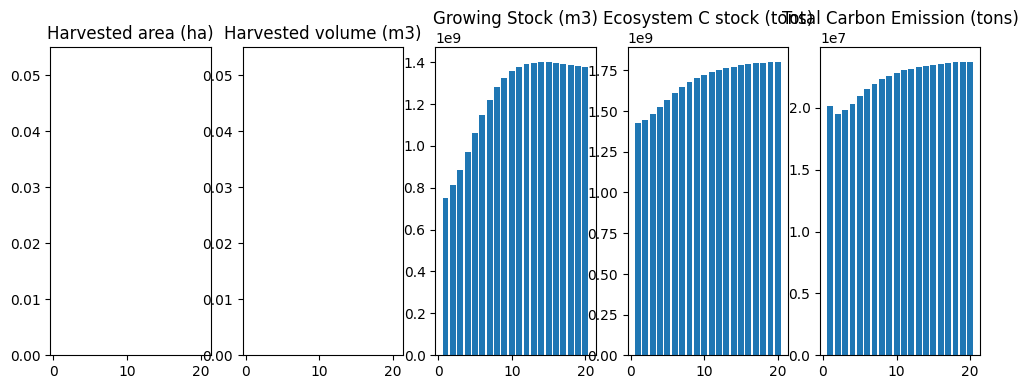

In [51]:
# Check the Forest Inventory of the ws3 Model
df = compile_scenario(fm)
plot_scenario(df)

In [52]:
# Import Modules
from util import cbm_report

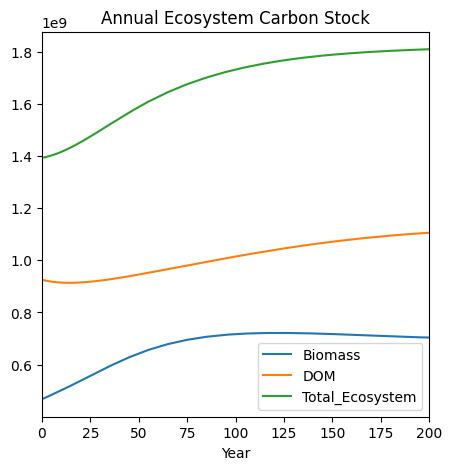

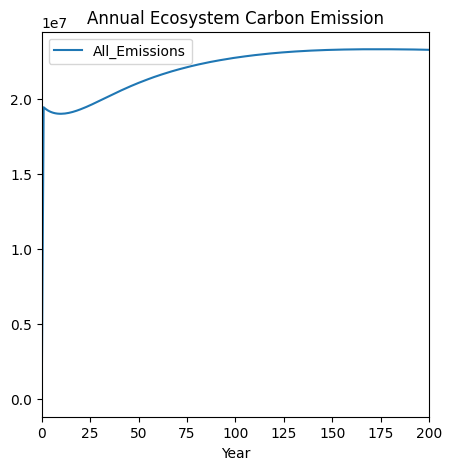

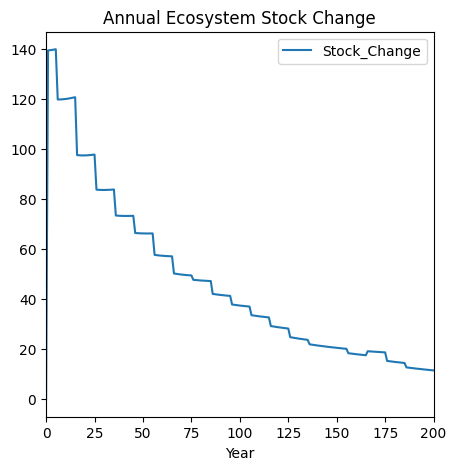

In [53]:
# Report Annual CBM Results
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes)

In [54]:
# Import Modules
from util import compare_ws3_cbm

(    period  biomass_stock     dom_stock     eco_stock  stock_change  \
 0        1   4.796492e+08  9.565485e+08  1.423559e+09  0.000000e+00   
 1        2   5.142598e+08  9.419251e+08  1.444523e+09  2.096404e+07   
 2        3   5.516939e+08  9.389819e+08  1.480075e+09  3.555202e+07   
 3        4   5.900462e+08  9.421992e+08  1.522888e+09  4.281269e+07   
 4        5   6.265684e+08  9.486787e+08  1.567339e+09  4.445040e+07   
 5        6   6.587581e+08  9.566048e+08  1.608842e+09  4.150381e+07   
 6        7   6.851254e+08  9.649711e+08  1.645046e+09  3.620380e+07   
 7        8   7.056831e+08  9.732088e+08  1.675493e+09  3.044672e+07   
 8        9   7.211902e+08  9.811078e+08  1.700542e+09  2.504884e+07   
 9       10   7.326948e+08  9.886318e+08  1.721025e+09  2.048331e+07   
 10      11   7.412027e+08  9.958119e+08  1.737875e+09  1.685031e+07   
 11      12   7.475899e+08  1.002472e+09  1.751685e+09  1.380958e+07   
 12      13   7.525242e+08  1.008553e+09  1.763060e+09  1.137481

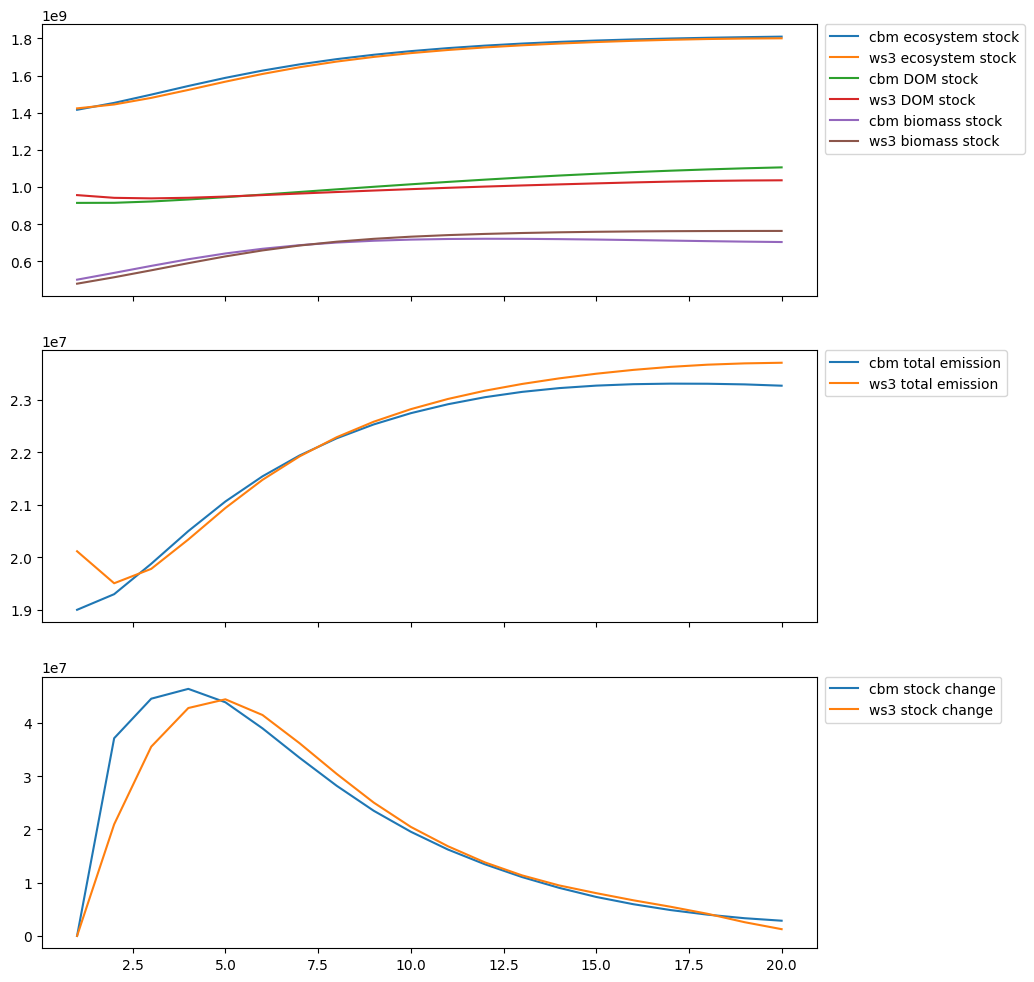

In [55]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, fluxes)

The carbon outputs from cbm and ws3 fit with each other pretty well when there is no harvest!

## Old-growth First Havresting Scenario

Simulate some harvesting in all periods

In [56]:
#Reset the Forest Model
fm.reset()
#Import Modules
from util import schedule_harvest_areacontrol, compile_scenario, plot_scenario
#Schedule Area Control Havrest
sch = schedule_harvest_areacontrol(fm)

(<Figure size 1200x400 with 5 Axes>,
 array([<Axes: title={'center': 'Harvested area (ha)'}>,
        <Axes: title={'center': 'Harvested volume (m3)'}>,
        <Axes: title={'center': 'Growing Stock (m3)'}>,
        <Axes: title={'center': 'Ecosystem C stock (tons)'}>,
        <Axes: title={'center': 'Total Carbon Emission (tons)'}>],
       dtype=object))

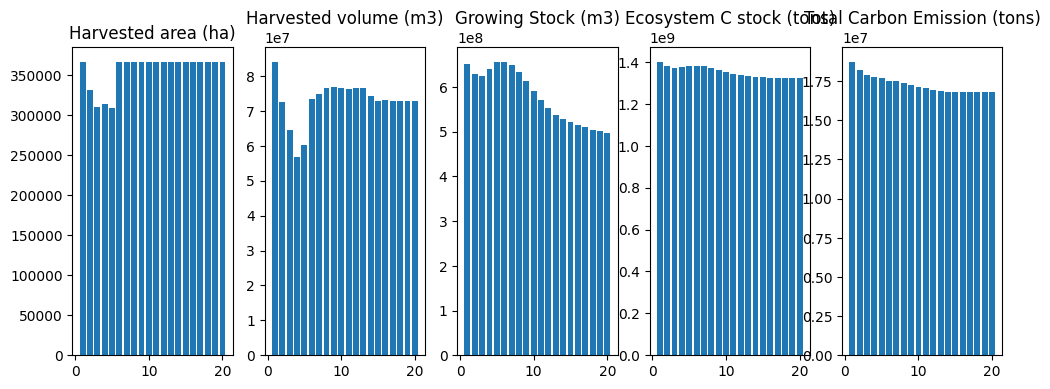

In [57]:
# Check the Forest Inventory of the Forest Model
df = compile_scenario(fm)
plot_scenario(df)

In [58]:
#Define Basic Variables
softwood_volume_yname='swdvol' 
hardwood_volume_yname='hwdvol'
n_yield_vals=100

In [59]:
#Import Module
from util import complie_events

In [60]:
#Generate New Sit_events file
sit_events = complie_events(fm, softwood_volume_yname, hardwood_volume_yname, n_yield_vals)

In [61]:
# Replace the Sit_events file in the sit tables
sit_tables['sit_events'] = sit_events

In [62]:
sit_events

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,min_softwood_age,max_softwood_age,min_hardwood_age,...,MinSWMerchStemSnagC,MaxSWMerchStemSnagC,MinHWMerchStemSnagC,MaxHWMerchStemSnagC,efficiency,sort_type,target_type,target,disturbance_type,disturbance_year
0,tsa24,1,2402004,104,2402004,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,105.100000,harvest,10
1,tsa24,1,2402004,104,2402004,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,52.100000,harvest,10
2,tsa24,1,2402004,104,2402004,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,9.600000,harvest,10
3,tsa24,1,2402004,104,2402004,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,59.900000,harvest,10
4,tsa24,1,2402004,104,2402004,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,38.700000,harvest,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,tsa24,1,2401002,204,2421002,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,23293.608387,harvest,200
787,tsa24,1,2403007,100,2423007,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,4865.113788,harvest,200
788,tsa24,1,2403007,100,2423007,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,3923.146988,harvest,200
789,tsa24,1,2403004,104,2423004,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,3022.314728,harvest,200


In [63]:
# Run CBM and Generate CBM Ouputs
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

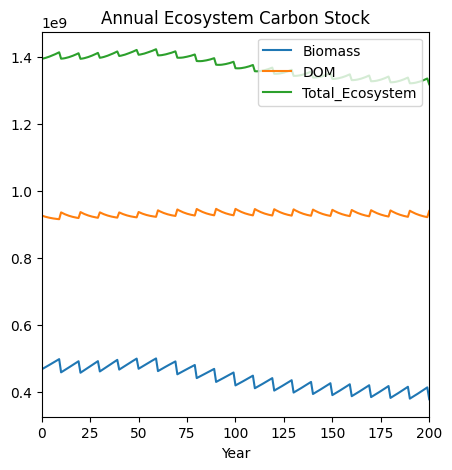

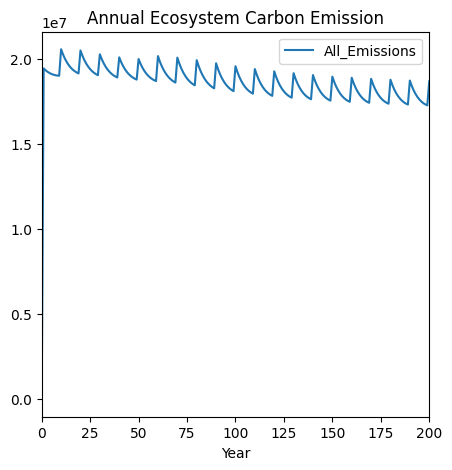

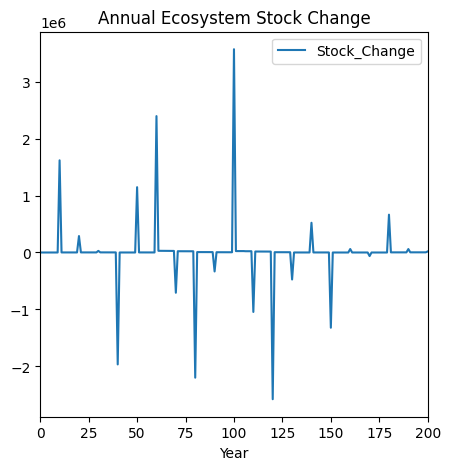

In [64]:
# Report Annual CBM Outputs
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes)

(    period  biomass_stock     dom_stock     eco_stock  stock_change  \
 0        1   4.350396e+08  9.775994e+08  1.400221e+09  0.000000e+00   
 1        2   4.309439e+08  9.609625e+08  1.380804e+09 -1.941746e+07   
 2        3   4.337253e+08  9.474691e+08  1.371528e+09 -9.276128e+06   
 3        4   4.420813e+08  9.413840e+08  1.375021e+09  3.493494e+06   
 4        5   4.493899e+08  9.370695e+08  1.379534e+09  4.512820e+06   
 5        6   4.487162e+08  9.393130e+08  1.382488e+09  2.954128e+06   
 6        7   4.450943e+08  9.385200e+08  1.379191e+09 -3.296708e+06   
 7        8   4.386655e+08  9.362542e+08  1.371444e+09 -7.747372e+06   
 8        9   4.312378e+08  9.336639e+08  1.362039e+09 -9.404797e+06   
 9       10   4.240007e+08  9.310868e+08  1.352614e+09 -9.425152e+06   
 10      11   4.177125e+08  9.290406e+08  1.344477e+09 -8.136820e+06   
 11      12   4.124739e+08  9.274139e+08  1.337659e+09 -6.818669e+06   
 12      13   4.083839e+08  9.258781e+08  1.331909e+09 -5.749144

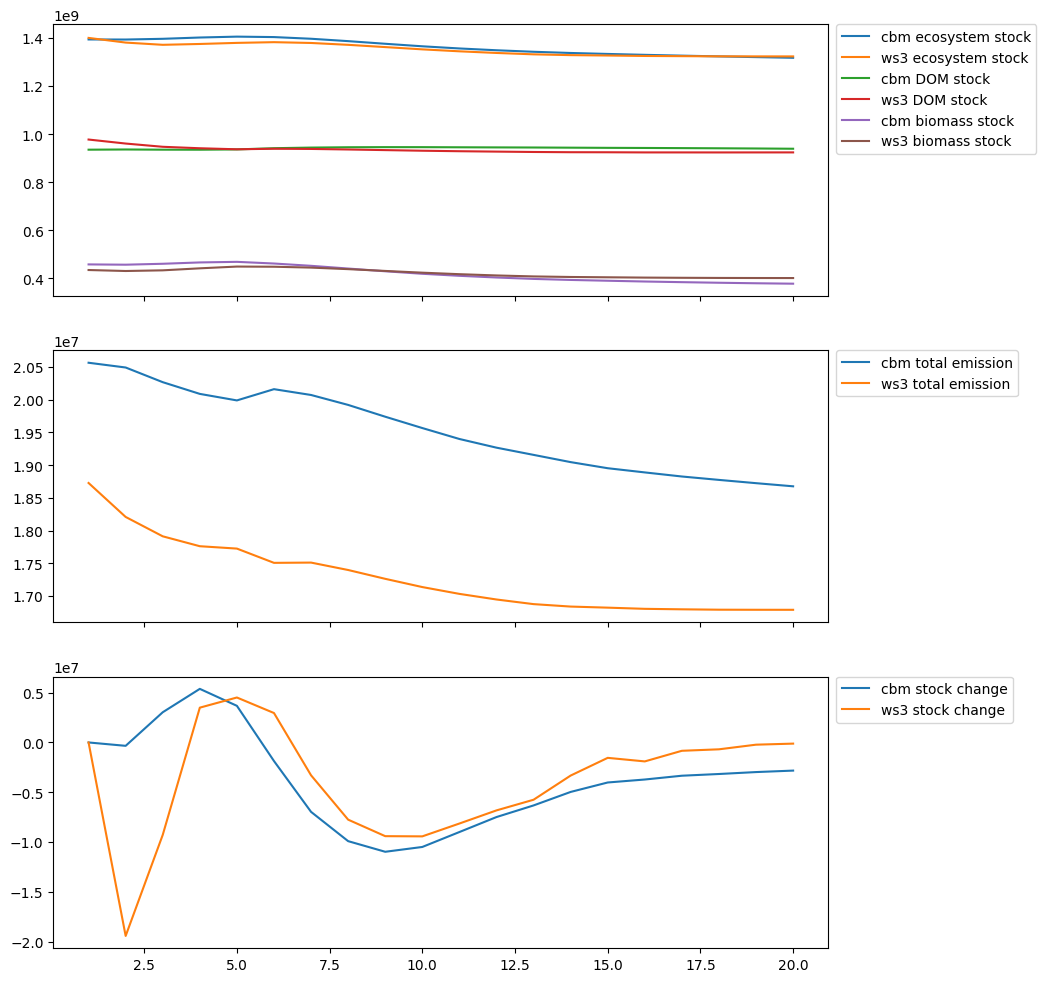

In [65]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, fluxes)

## Implement Optimization-based Action Scheduling

In [66]:
#Install Module
%pip install gurobipy

Note: you may need to restart the kernel to use updated packages.


In [67]:
#Import Module
import gurobipy as grb

In [68]:
#Import Module
# from util import cmp_c_z,cmp_c_cflw,cmp_c_caa,cmp_c_ci,gen_scenario

Add a "null" action to the model for the optimization functions to work correctly.

In [69]:
#Add a Null Action
fm.add_null_action()

Define base and other scenarios below. You can change you objective functions and constraints by modifying the scenarios directly.

In [73]:
# Define Objective Function
def cmp_c_z(fm, path, expr):
    """
    Compile objective function coefficient for product indicators (given ForestModel instance, 
    leaf-to-root-node path, and expression to evaluate).
    """
    result = 0.
    for t, n in enumerate(path, start=1):
        d = n.data()
        if fm.is_harvest(d['acode']):
            result += fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False)
    return result

def cmp_c_i(fm, path, yname, mask=None): # product, named actions
    """
    Compile objective function coefficient for inventory indicator (given ForestModel instance, 
    leaf-to-root-node path, expression to evaluate, and optional mask).
    """
    result = 0.
    for t, n in enumerate(path, start=1):
        d = n.data()
        if mask and not fm.match_mask(mask, d['dtk']): continue
        result += fm.inventory(t, yname=yname, age=d['age'], dtype_keys=[d['dtk']])
        #result[t] = fm.inventory(t, yname=yname, age=d['age'], dtype_keys=[d['dtk']])
    return result

def cmp_c_cflw(fm, path, expr, mask=None): # product, all harvest actions
    """
    Compile flow constraint coefficient for product indicator (given ForestModel 
    instance, leaf-to-root-node path, expression to evaluate, and optional mask).
    """
    result = {}
    for t, n in enumerate(path, start=1):
        d = n.data()
        if mask and not fm.match_mask(mask, d['dtk']): continue
        if fm.is_harvest(d['acode']):
            result[t] = fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False)
    return result


def cmp_c_caa(fm, path, expr, acodes, mask=None): # product, named actions
    """
    Compile constraint coefficient for product indicator (given ForestModel 
    instance, leaf-to-root-node path, expression to evaluate, list of action codes, 
    and optional mask).
    """
    result = {}
    for t, n in enumerate(path, start=1):
        d = n.data()
        if mask and not fm.match_mask(mask, d['dtk']): continue
        if d['acode'] in acodes:
            result[t] = fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False)
    return result


def cmp_c_ci(fm, path, yname, mask=None): # product, named actions
    """
    Compile constraint coefficient for inventory indicator (given ForestModel instance, 
    leaf-to-root-node path, expression to evaluate, and optional mask).
    """
    result = {}
    for t, n in enumerate(path, start=1):
        d = n.data()
        if mask and not fm.match_mask(mask, d['_dtk']): continue
        result[t] = fm.inventory(t, yname=yname, age=d['_age'], dtype_keys=[d['_dtk']]) 
        #result[t] = fm.inventory(t, yname=yname, age=d['age'], dtype_keys=[d['dtk']]) 
    return result

In [125]:
# Define Gen_scenario Function
def gen_scenario(fm, name='base', util=0.85, harvest_acode='harvest',
                 cflw_ha={}, cflw_hv={}, 
                 cgen_ha={}, cgen_hv={}, 
                 cgen_gs={}, cgen_cp = {}, cgen_cf = {},
                 tvy_name='totvol', cp_name='ecosystem', cf_name='total_emissions', obj_mode='max_iv', mask=None):
    from functools import partial
    import numpy as np
    coeff_funcs = {}
    cflw_e = {}
    cgen_data = {}
    acodes = ['null', harvest_acode] # define list of action codes
    vexpr = '%s * %0.2f' % (tvy_name, util) # define volume expression
    if obj_mode == 'max_hv': # maximize harvest volume
        sense = ws3.opt.SENSE_MAXIMIZE 
        zexpr = vexpr
    elif obj_mode == 'min_hv': # maximize harvest volume
        sense = ws3.opt.SENSE_MINIMIZE 
        zexpr = vexpr
    elif obj_mode == 'max_iv': # minimize forest inventory values
        sense = ws3.opt.SENSE_MAXIMIZE 
        zexpr = '1.'
    elif obj_mode == 'min_iv': # minimize forest inventory values
        sense = ws3.opt.SENSE_MINIMIZE 
        zexpr = '1.'
    elif obj_mode == 'min_ha': # minimize harvest area
        sense = ws3.opt.SENSE_MINIMIZE 
        zexpr = '1.'
    else:
        raise ValueError('Invalid obj_mode: %s' % obj_mode)        
    coeff_funcs['z'] = partial(cmp_c_i, yname=cp_name) # define objective function coefficient function for inventory data
    # coeff_funcs['z'] = partial(cmp_c_z, expr=cp_name) # define objective function coefficient function for harvested carbon 
    # coeff_funcs['z'] = partial(cmp_c_z, expr=vexpr) # define objective function coefficient function for havrest volume 
    T = fm.periods
    if cflw_ha: # define even flow constraint (on harvest area)
        cname = 'cflw_ha'
        coeff_funcs[cname] = partial(cmp_c_caa, expr='1.', acodes=[harvest_acode], mask=None) 
        cflw_e[cname] = cflw_ha
    if cflw_hv: # define even flow constraint (on harvest volume)
        cname = 'cflw_hv'
        coeff_funcs[cname] = partial(cmp_c_caa, expr=vexpr, acodes=[harvest_acode], mask=None) 
        # cflw_e[cname] = cflw_hv         
    if cgen_ha: # define general constraint (harvest area)
        cname = 'cgen_ha'
        coeff_funcs[cname] = partial(cmp_c_caa, expr='1.', acodes=[harvest_acode], mask=None) 
        cgen_data[cname] = cgen_ha
    if cgen_hv: # define general constraint (harvest volume)
        cname = 'cgen_hv'
        coeff_funcs[cname] = partial(cmp_c_caa, expr=vexpr, acodes=[harvest_acode], mask=None) 
        cgen_data[cname] = cgen_hv
    if cgen_gs: # define general constraint (growing stock)
        cname = 'cgen_gs'
        coeff_funcs[cname] = partial(cmp_c_ci, yname=tvy_name, mask=None)
        cgen_data[cname] = cgen_gs
    if cgen_cp: # define general constraint (carbon pools)
        cname = 'cgen_cp'
        coeff_funcs[cname] = partial(cmp_c_ci, yname=cp_name, mask=None)
        cgen_data[cname] = cgen_cp
    if cgen_cf: # define general constraint (carbon fluxes)
        cname = 'cgen_cf'
        coeff_funcs[cname] = partial(cmp_c_ci, yname=cf_name, mask=None)
        cgen_data[cname] = cgen_cf
    return fm.add_problem(name, coeff_funcs, cflw_e, cgen_data=cgen_data, acodes=acodes, sense=sense, mask=mask)

In [126]:
# Define Run_scenario Function
def run_scenario(fm, scenario_name='base'):
    cflw_ha = {}
    cflw_hv = {}
    cgen_ha = {}
    cgen_hv = {}
    cgen_gs = {}
    cgen_cp = {}
    cgen_cf = {}
    
    # define harvest area and harvest volume even-flow constraints
    cflw_ha = ({p:0.05 for p in fm.periods}, 1)
    cflw_hv = ({p:0.05 for p in fm.periods}, 1)
    
    in_gs = 750290200. #initial growing stock volume
    in_cp = 1412181000. #initial total ecosystem carbon stock
    # in_cf = 580000000 #intial total ecosystem carbon emission
    AAC = 7031963. # AAC of TSA24

    if scenario_name == 'base': 
        # Base scenario
        print('running base scenario')
        # cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*2}} #Not less than 90% of initial growing stock
        cgen_hv = {'lb':{10:in_gs*10}, 'ub':{10:in_gs*10+1}}
    elif scenario_name == 'base_h': 
        # Base scenario
        print('running maxmizie harvest scenario')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*2}} #Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC-1}, 'ub':{1:AAC}} #Achieve the Annual Allowable Cut
    elif scenario_name == 'base_c': 
        # Cabron indicators constraints
        print('running base scenario with even-flow constraints')
        # cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*2}} #Not less than 90% of initial growing stock
        # cgen_hv = {'lb':{1:AAC*0.5}, 'ub':{1:AAC*2}}  #Not less than 10% of annual allowable cut
        # cgen_cf = {'lb':{10:in_cf}, 'ub':{10:in_cf*1.1}} #Not more than 110% of initial total ecosystem carbon stock
    elif scenario_name == 'reduce_10%_AAC': 
        # Reduce 10% of harvest volume from base scenario
        print('running base scenario reduced 10% of AAC')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*0.9+1}}#Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC*0.9-1}, 'ub':{1:AAC*0.9}}    
    elif scenario_name == 'reduce_20%_AAC': 
        # Reduce 20% of harvest volume from base scenario
        print('running base scenario reduced 20% of AAC')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*0.9+1}} #Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC*0.8-1}, 'ub':{1:AAC*0.8}}   
    elif scenario_name == 'increase_10%_AAC': 
        # Increase 10% of harvest volume from base scenario
        print('running base scenario increased 10% of AAC')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*0.9+1}} #Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC*1.1-1}, 'ub':{1:AAC*1.1}}
    elif scenario_name == 'increase_20%_AAC': 
        # Increase 20% of harvest volume from base scenario
        print('running base scenario increased 20% of AAC')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*0.9+1}} #Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC*1.2-1}, 'ub':{1:AAC*1.2}}   
    else:
        assert False # bad scenario name
      
    # p = gen_scenario(fm=fm, 
    #                  name=scenario_name, 
    #                  cflw_ha=cflw_ha, 
    #                  cflw_hv=cflw_hv,
    #                  cgen_ha=cgen_ha,
    #                  cgen_hv=cgen_hv,
    #                  cgen_gs=cgen_gs)
    
    p = gen_scenario(fm=fm, 
                     name=scenario_name, 
                     cflw_ha=cflw_ha, 
                     cflw_hv=cflw_hv,
                     cgen_ha=cgen_ha,
                     cgen_hv=cgen_hv,
                     cgen_gs=cgen_gs,
                     cgen_cp=cgen_cp,
                     cgen_cf=cgen_cf)

    fm.reset()
    m = p.solve()

    if m.status != grb.GRB.OPTIMAL:
        print('Model not optimal.')
        # sys.exit()
        
    sch = fm.compile_schedule(p)
    fm.apply_schedule(sch, 
                      force_integral_area=False, 
                      override_operability=False,
                      fuzzy_age=False,
                      recourse_enabled=False,
                      verbose=False,
                      compile_c_ycomps=True)
    
    from util import compile_scenario, plot_scenario
    df = compile_scenario(fm)
    fig, ax = plot_scenario(df)
    # cbm_results = cbm_hardlink(fm,disturbance_type_mapping)
    
    return fig, df, p

## Maximize Havrest Volume without Any Constraints

running base scenario
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-22
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 812 rows, 45499 columns and 495051 nonzeros
Model fingerprint: 0x3bed9c49
Coefficient statistics:
  Matrix range     [2e-01, 4e+07]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 332 rows and 770 columns
Presolve time: 0.05s

Solved in 0 iterations and 0.05 seconds (0.03 work units)
Infeasible model
foo
ws3.opt._solve_gurobi: Model infeasible, enabling feasRelaxS mode.
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Pro

(<Figure size 1200x400 with 5 Axes>,
     period           oha           ohv           ogs           ocp  \
 0        1  2.289161e+06  3.983687e+08  2.807357e+08  1.322827e+09   
 1        2  1.293445e+05  1.899607e+07  2.984169e+08  1.212549e+09   
 2        3  7.697398e+04  1.163613e+07  3.371078e+08  1.181091e+09   
 3        4  9.615824e+04  1.294637e+07  3.876348e+08  1.190214e+09   
 4        5  1.145236e+05  1.759726e+07  4.430842e+08  1.222509e+09   
 5        6  2.421784e+05  3.449124e+07  4.944986e+08  1.265553e+09   
 6        7  3.399797e+05  6.286213e+07  5.216759e+08  1.300692e+09   
 7        8  3.395785e+05  6.425564e+07  5.482449e+08  1.324116e+09   
 8        9  2.367823e+06  1.910121e+08  4.191062e+08  1.401561e+09   
 9       10  2.198777e+05  7.613954e+07  3.508624e+08  1.269299e+09   
 10      11  2.263006e+05  3.110309e+07  3.399097e+08  1.219865e+09   
 11      12  1.055715e+05  1.350511e+07  3.578970e+08  1.203585e+09   
 12      13  1.182018e+05  1.658017e+07 

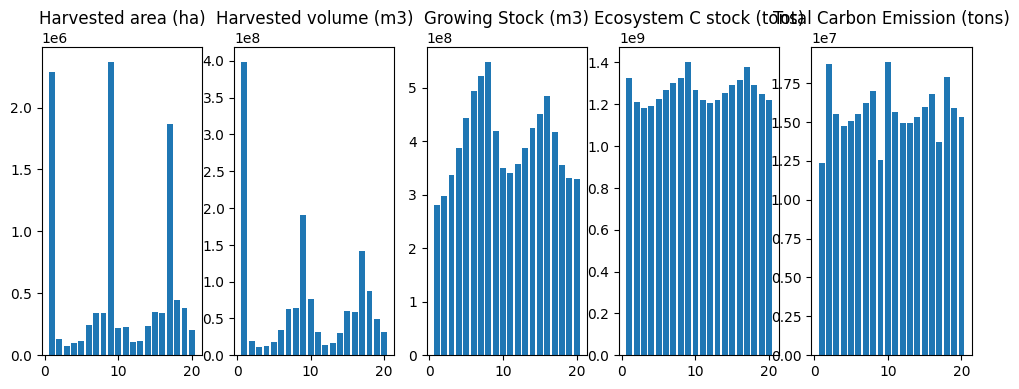

In [77]:
run_scenario(fm,'base')

In [78]:
#Generate New Sit_events file
sit_events = complie_events(fm, softwood_volume_yname, hardwood_volume_yname, n_yield_vals)

In [79]:
# Replace the Sit_events file in the sit tables
sit_tables['sit_events'] = sit_events

In [80]:
# Run CBM and Generate CBM Ouputs
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

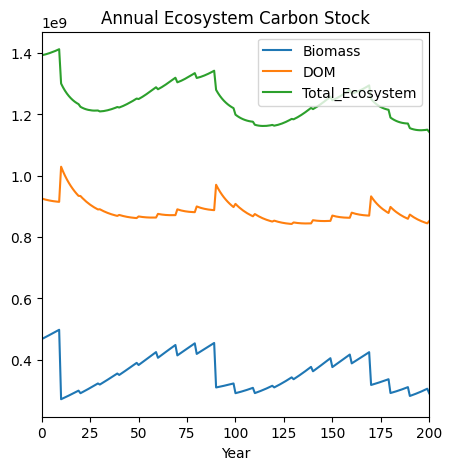

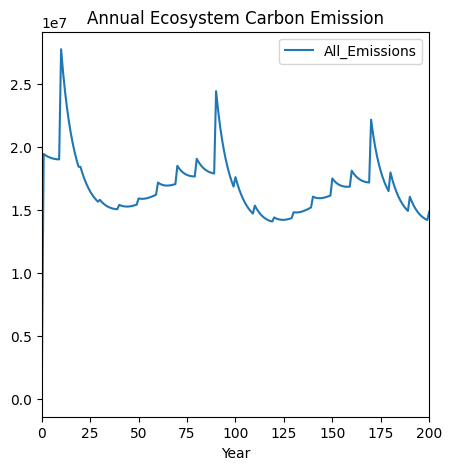

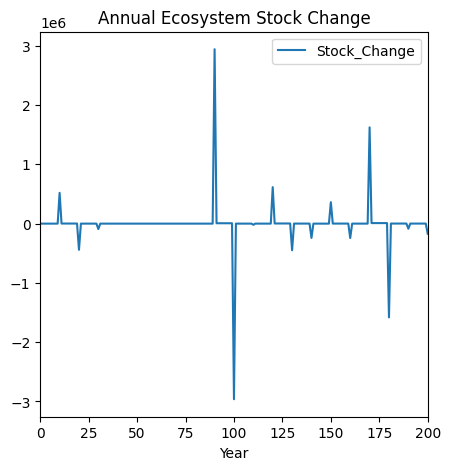

In [81]:
# Report Annual CBM Outputs
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes)

(    period  biomass_stock     dom_stock     eco_stock  stock_change  \
 0        1   2.508662e+08  1.076500e+09  1.322827e+09  0.000000e+00   
 1        2   2.668628e+08  9.498840e+08  1.212549e+09 -1.102772e+08   
 2        3   2.932195e+08  8.917099e+08  1.181091e+09 -3.145793e+07   
 3        4   3.269712e+08  8.675703e+08  1.190214e+09  9.122139e+06   
 4        5   3.642283e+08  8.607935e+08  1.222509e+09  3.229574e+07   
 5        6   3.937071e+08  8.730490e+08  1.265553e+09  4.304342e+07   
 6        7   4.094184e+08  8.929879e+08  1.300692e+09  3.513904e+07   
 7        8   4.203377e+08  9.064675e+08  1.324116e+09  2.342436e+07   
 8        9   3.154799e+08  1.086938e+09  1.401561e+09  7.744522e+07   
 9       10   2.954157e+08  9.755407e+08  1.269299e+09 -1.322623e+08   
 10      11   2.970575e+08  9.242029e+08  1.219865e+09 -4.943417e+07   
 11      12   3.177817e+08  8.879830e+08  1.203585e+09 -1.628028e+07   
 12      13   3.470443e+08  8.741822e+08  1.220134e+09  1.654937

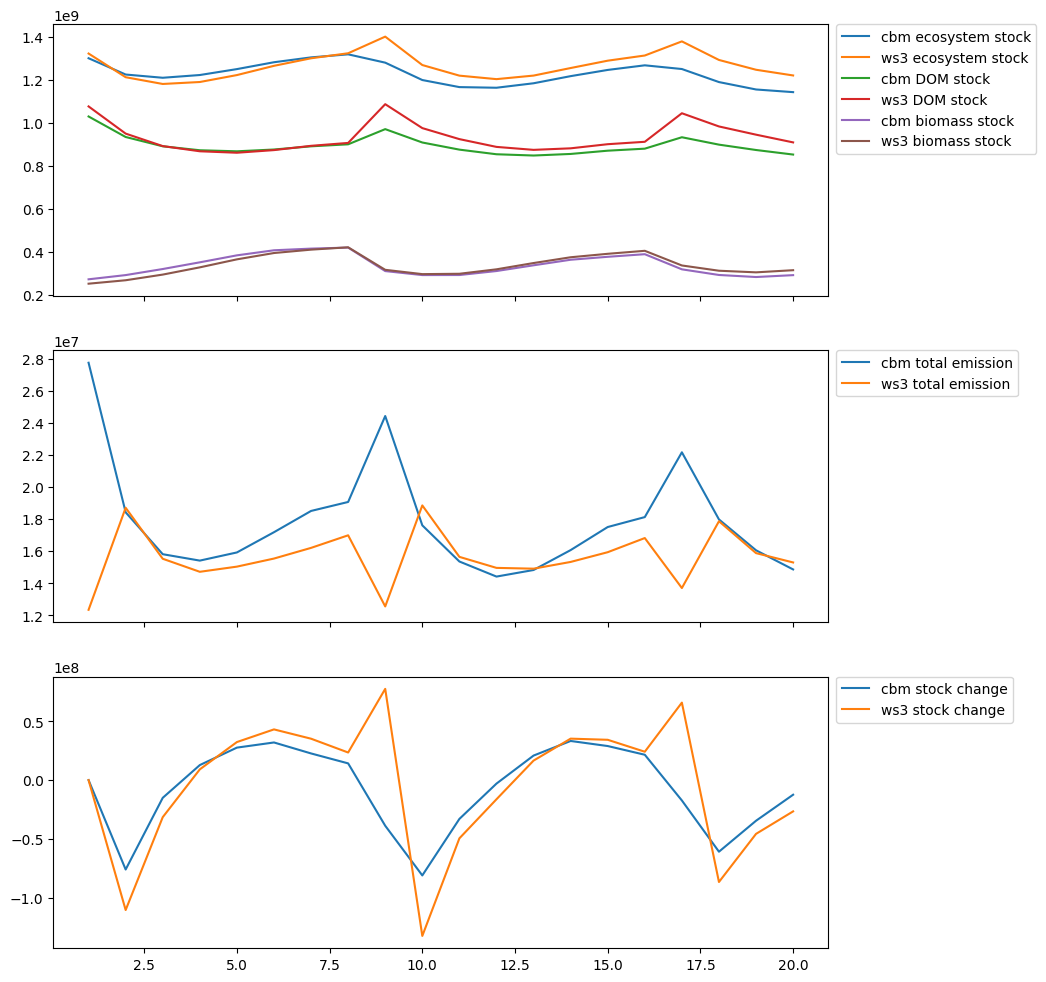

In [82]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, fluxes)

In [83]:
print('It took ', round((time.time()-Start)/60, 1), " minutes to run this script.")

It took  4.6  minutes to run this script.


## Maximize Havrest Volume with Harvesting and Growing Stock Constraints

running maxmizie harvest scenario
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 814 rows, 45499 columns and 557773 nonzeros
Model fingerprint: 0x4db2bc24
Coefficient statistics:
  Matrix range     [2e-01, 5e+07]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 333 rows and 330 columns
Presolve time: 0.28s
Presolved: 481 rows, 45170 columns, 513804 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.790e+04
 Factor NZ  : 2.348e+04 (roughly 20 MB of memory)
 Factor Ops : 1.239e+06 (less than 1 second pe

(<Figure size 1200x400 with 5 Axes>,
     period           oha           ohv           ogs           ocp  \
 0        1  22998.040723  7.031963e+06  7.411319e+08  1.422085e+09   
 1        2  21848.138687  2.226362e+06  8.015575e+08  1.440800e+09   
 2        3  21848.138687  2.634089e+06  8.719442e+08  1.473758e+09   
 3        4  21848.138687  2.474030e+06  9.533874e+08  1.514128e+09   
 4        5  21848.138687  2.695289e+06  1.040235e+09  1.556210e+09   
 5        6  21848.138687  3.557302e+06  1.122618e+09  1.595480e+09   
 6        7  21848.138687  3.027060e+06  1.193749e+09  1.629182e+09   
 7        8  21848.138687  2.989918e+06  1.250253e+09  1.657418e+09   
 8        9  21848.138687  3.151331e+06  1.292496e+09  1.681070e+09   
 9       10  21848.138687  8.728331e+05  1.325140e+09  1.701395e+09   
 10      11  21848.138687  4.168337e+06  1.343853e+09  1.717195e+09   
 11      12  21848.138687  1.386540e+06  1.358029e+09  1.730668e+09   
 12      13  21848.138687  2.748696e+06 

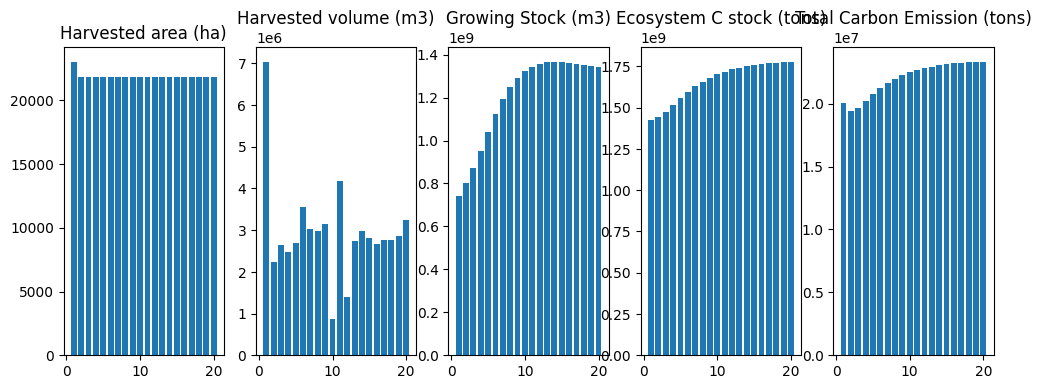

In [84]:
run_scenario(fm,'base_h')

In [85]:
#Generate New Sit_events file
sit_events = complie_events(fm, softwood_volume_yname, hardwood_volume_yname, n_yield_vals)

In [86]:
# Replace the Sit_events file in the sit tables
sit_tables['sit_events'] = sit_events

In [87]:
# Run CBM and Generate CBM Ouputs
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

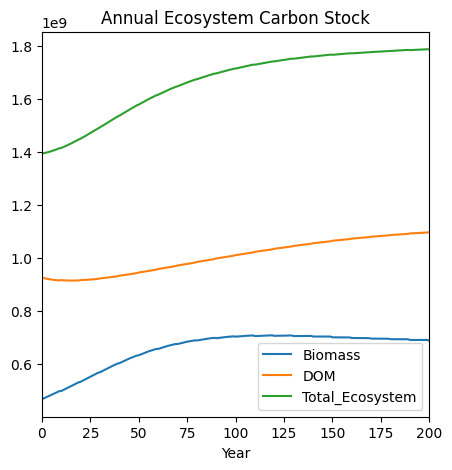

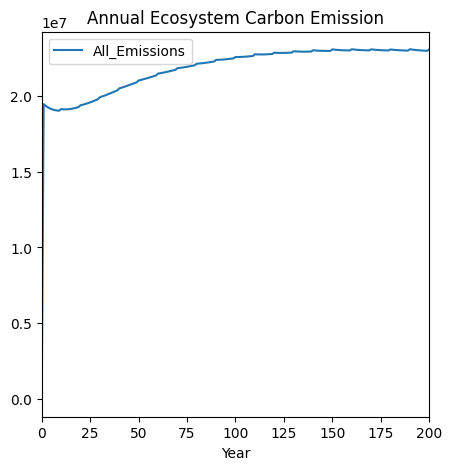

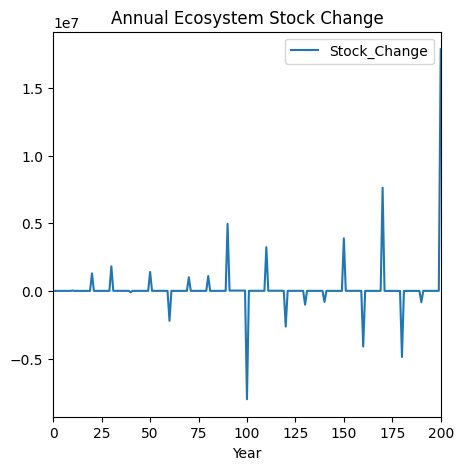

In [88]:
# Report Annual CBM Outputs
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes)

(    period  biomass_stock     dom_stock     eco_stock  stock_change  \
 0        1   4.762407e+08  9.584669e+08  1.422085e+09  0.000000e+00   
 1        2   5.092869e+08  9.430351e+08  1.440800e+09  1.871563e+07   
 2        3   5.450090e+08  9.391357e+08  1.473758e+09  3.295742e+07   
 3        4   5.819035e+08  9.413534e+08  1.514128e+09  4.037024e+07   
 4        5   6.169887e+08  9.468169e+08  1.556210e+09  4.208237e+07   
 5        6   6.476730e+08  9.540224e+08  1.595480e+09  3.926987e+07   
 6        7   6.729287e+08  9.611414e+08  1.629182e+09  3.370210e+07   
 7        8   6.925622e+08  9.682249e+08  1.657418e+09  2.823524e+07   
 8        9   7.072150e+08  9.756812e+08  1.681070e+09  2.365204e+07   
 9       10   7.188866e+08  9.829843e+08  1.701395e+09  2.032552e+07   
 10      11   7.262429e+08  9.902921e+08  1.717195e+09  1.579997e+07   
 11      12   7.326852e+08  9.966373e+08  1.730668e+09  1.347277e+07   
 12      13   7.371465e+08  1.002684e+09  1.741535e+09  1.086684

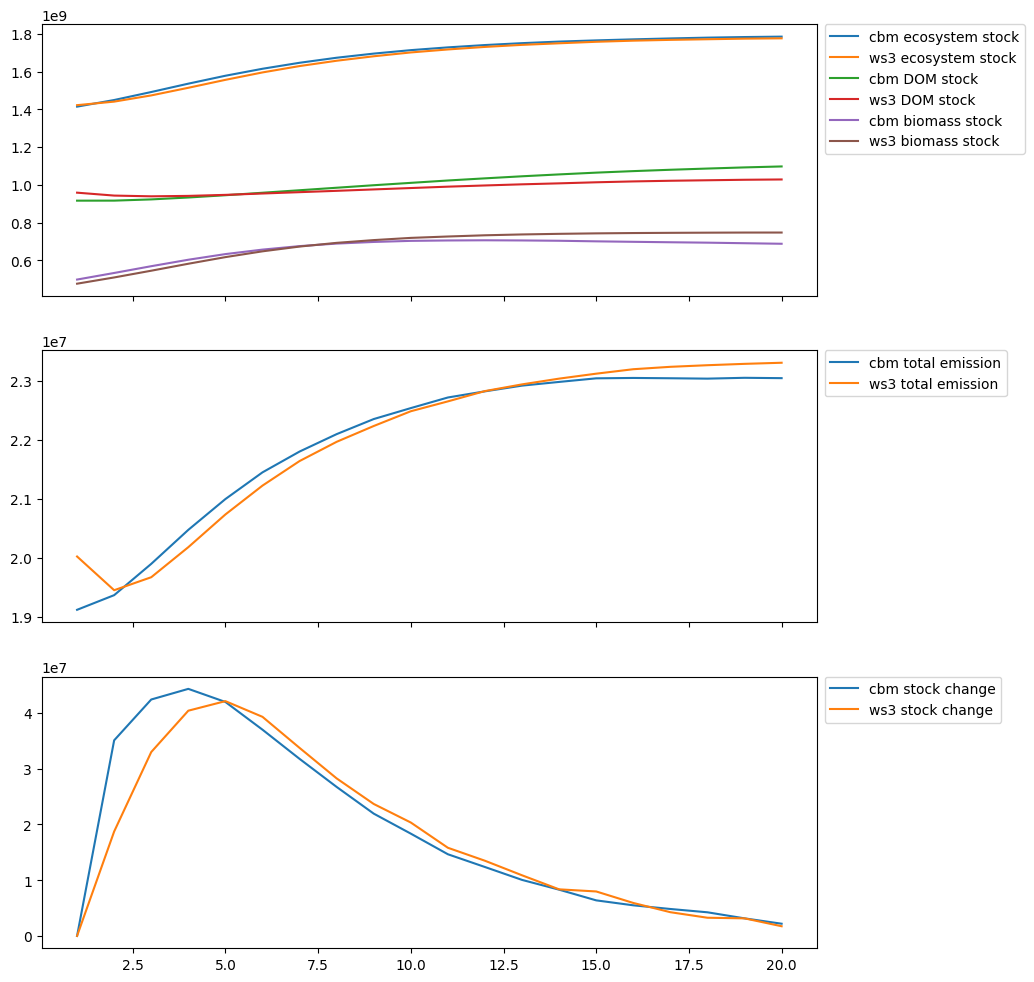

In [89]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, fluxes)

The Carbon Outputs from ws3 and libcbm still looks good when maxmizing the harvest volum from the forest

In [90]:
print('It took ', round((time.time()-Start)/60, 1), " minutes to run this script.")

It took  6.0  minutes to run this script.


## Maximize Total Ecosystem Carbon Storage without Any Constraints

running base scenario with even-flow constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 810 rows, 45499 columns and 486195 nonzeros
Model fingerprint: 0xadac3480
Coefficient statistics:
  Matrix range     [2e-01, 1e+05]
  Objective range  [7e+03, 9e+08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 332 rows and 330 columns
Presolve time: 0.21s
Presolved: 478 rows, 45169 columns, 470823 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier performed 0 iterations in 0.32 seconds (0.14 work units)
Barrier solve interrupted - model solved by another algorithm


Solved with primal simplex
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3

(<Figure size 1200x400 with 5 Axes>,
     period  oha  ohv           ogs           ocp           ocf
 0        1  0.0  0.0  7.494048e+08  1.423559e+09  2.011735e+07
 1        2  0.0  0.0  8.124675e+08  1.444523e+09  1.950935e+07
 2        3  0.0  0.0  8.861458e+08  1.480075e+09  1.978305e+07
 3        4  0.0  0.0  9.707337e+08  1.522888e+09  2.034091e+07
 4        5  0.0  0.0  1.060630e+09  1.567339e+09  2.093942e+07
 5        6  0.0  0.0  1.146251e+09  1.608842e+09  2.147404e+07
 6        7  0.0  0.0  1.219698e+09  1.645046e+09  2.191968e+07
 7        8  0.0  0.0  1.278276e+09  1.675493e+09  2.228341e+07
 8        9  0.0  0.0  1.322490e+09  1.700542e+09  2.257847e+07
 9       10  0.0  0.0  1.354309e+09  1.721025e+09  2.281689e+07
 10      11  0.0  0.0  1.376027e+09  1.737875e+09  2.301058e+07
 11      12  0.0  0.0  1.389710e+09  1.751685e+09  2.316757e+07
 12      13  0.0  0.0  1.397148e+09  1.763060e+09  2.329571e+07
 13      14  0.0  0.0  1.399821e+09  1.772547e+09  2.340176e+07
 14

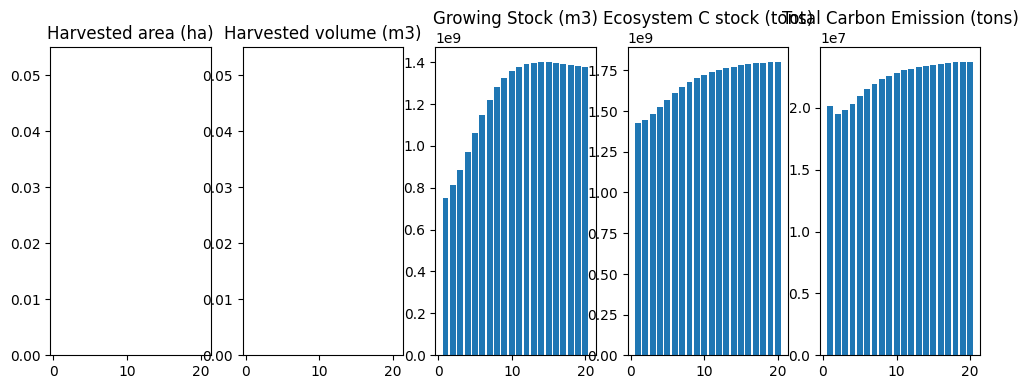

In [127]:
# Maximize Total Ecosystem Carbon Storage
run_scenario(fm,'base_c')

In [128]:
#Generate New Sit_events file
sit_events = complie_events(fm, softwood_volume_yname, hardwood_volume_yname, n_yield_vals)

In [129]:
# Replace the Sit_events file in the sit tables
sit_tables['sit_events'] = sit_events

In [130]:
# Run CBM and Generate CBM Ouputs
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

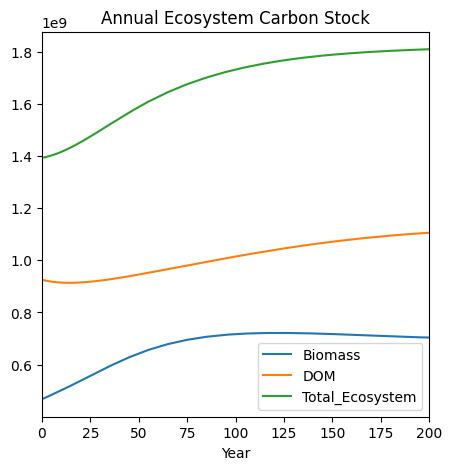

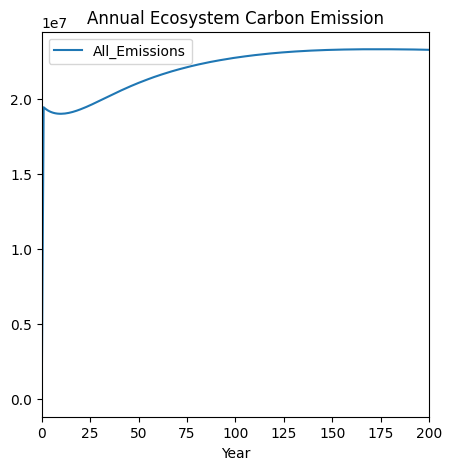

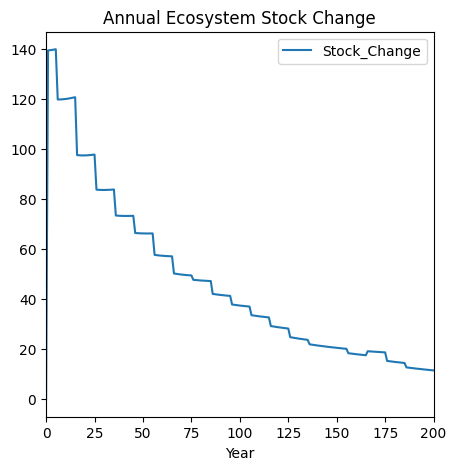

In [131]:
# Report Annual CBM Outputs
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes)

(    period  biomass_stock     dom_stock     eco_stock  stock_change  \
 0        1   4.796492e+08  9.565485e+08  1.423559e+09  0.000000e+00   
 1        2   5.142598e+08  9.419251e+08  1.444523e+09  2.096404e+07   
 2        3   5.516939e+08  9.389819e+08  1.480075e+09  3.555202e+07   
 3        4   5.900462e+08  9.421992e+08  1.522888e+09  4.281269e+07   
 4        5   6.265684e+08  9.486787e+08  1.567339e+09  4.445040e+07   
 5        6   6.587581e+08  9.566048e+08  1.608842e+09  4.150381e+07   
 6        7   6.851254e+08  9.649711e+08  1.645046e+09  3.620380e+07   
 7        8   7.056831e+08  9.732088e+08  1.675493e+09  3.044672e+07   
 8        9   7.211902e+08  9.811078e+08  1.700542e+09  2.504884e+07   
 9       10   7.326948e+08  9.886318e+08  1.721025e+09  2.048331e+07   
 10      11   7.412027e+08  9.958119e+08  1.737875e+09  1.685031e+07   
 11      12   7.475899e+08  1.002472e+09  1.751685e+09  1.380958e+07   
 12      13   7.525242e+08  1.008553e+09  1.763060e+09  1.137481

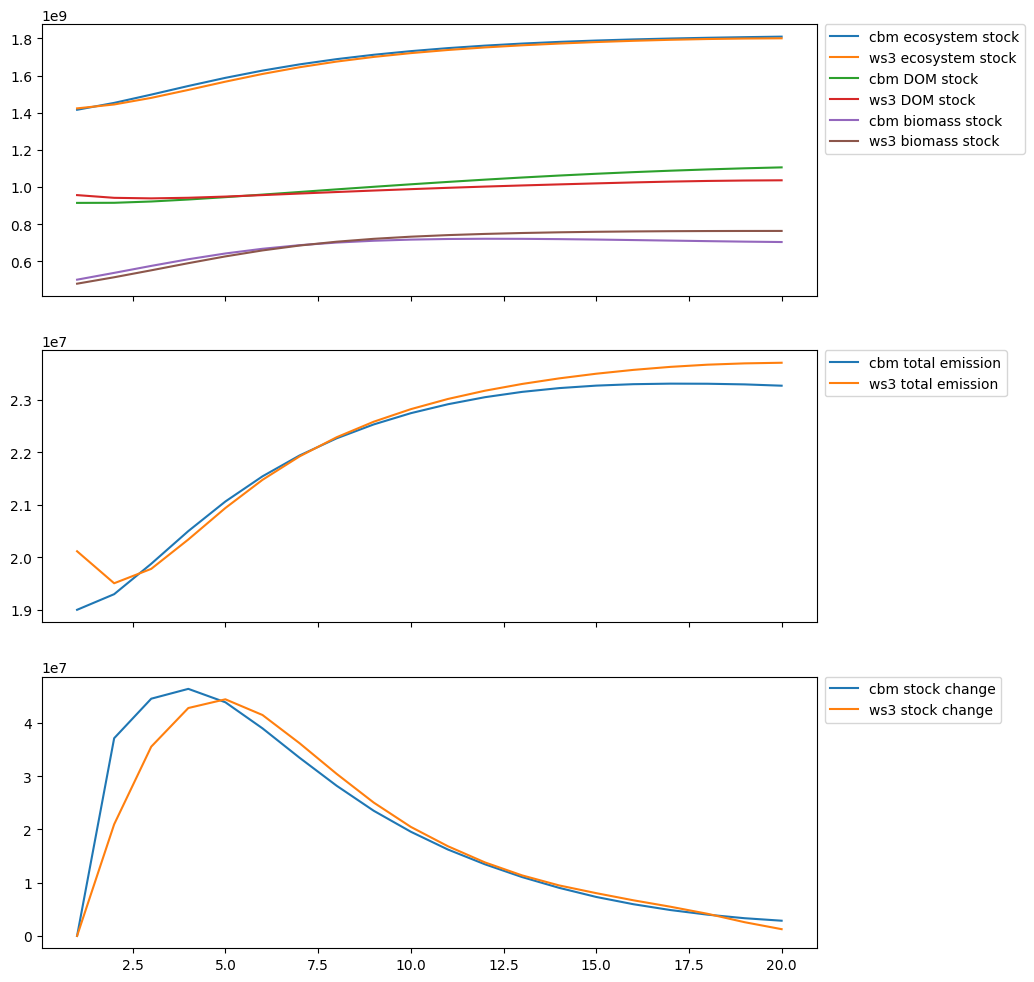

In [132]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, fluxes)

In [133]:
print('It took ', round((time.time()-Start)/60, 1), " minutes to run this script.")

It took  27.5  minutes to run this script.


There will be the least harvesting activities if the target is to maxmize the total ecosystem carbon stock

## Maximize Total Ecosystem Carbon Storage with Harvesting and Growing Stock Constraints

running base scenario with even-flow constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 814 rows, 45499 columns and 557773 nonzeros
Model fingerprint: 0x28066f0e
Coefficient statistics:
  Matrix range     [2e-01, 5e+07]
  Objective range  [1e+02, 1e+07]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 334 rows and 330 columns
Presolve time: 0.25s
Presolved: 480 rows, 45171 columns, 506284 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.753e+04
 Factor NZ  : 2.306e+04 (roughly 20 MB of memory)
 Factor Ops : 1.195e+06 (less t

(<Figure size 1200x400 with 5 Axes>,
     period           oha           ohv           ogs           ocp  \
 0        1  10702.042766  3.515982e+06  7.452683e+08  1.422930e+09   
 1        2  10166.940628  2.254932e+06  8.056441e+08  1.442971e+09   
 2        3  10166.940628  2.556618e+06  8.760518e+08  1.477181e+09   
 3        4  10166.940628  2.919244e+06  9.567992e+08  1.518425e+09   
 4        5  10166.940628  3.148669e+06  1.042853e+09  1.561301e+09   
 5        6  10166.940628  3.201031e+06  1.125348e+09  1.601427e+09   
 6        7  10166.940628  5.098721e+05  1.199864e+09  1.637398e+09   
 7        8  10166.940628  5.098721e+05  1.260175e+09  1.668056e+09   
 8        9  10166.940628  5.098721e+05  1.306643e+09  1.693560e+09   
 9       10  10166.940628  8.623821e+05  1.340643e+09  1.714352e+09   
 10      11  10166.940628  2.847161e+06  1.362259e+09  1.730813e+09   
 11      12  10166.940628  2.635264e+06  1.375866e+09  1.743925e+09   
 12      13  10166.940628  2.425255e+06 

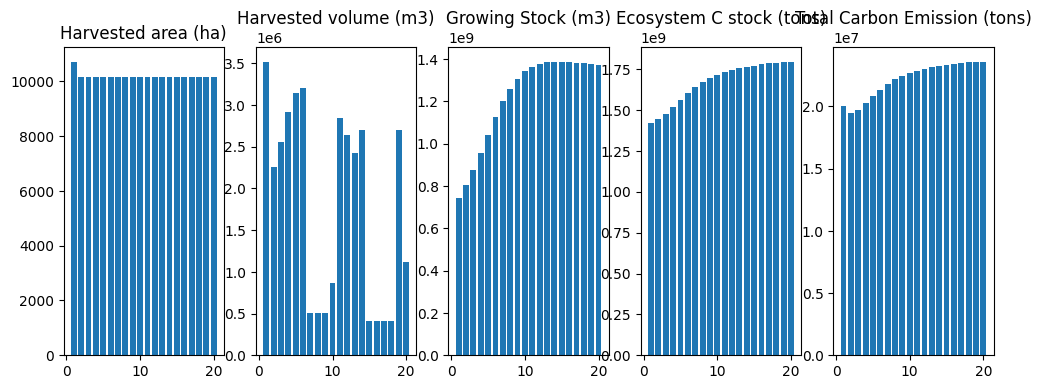

In [117]:
# Maximize Total Ecosystem Carbon Storage with Minimum and Maximum Harvest  Level and Total Growing Stock Constraints
run_scenario(fm,'base_c')

In [118]:
#Generate New Sit_events file
sit_events = complie_events(fm, softwood_volume_yname, hardwood_volume_yname, n_yield_vals)

In [119]:
# Replace the Sit_events file in the sit tables
sit_tables['sit_events'] = sit_events

In [120]:
# Run CBM and Generate CBM Ouputs
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

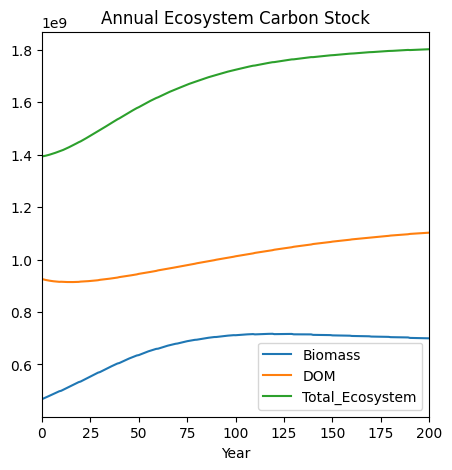

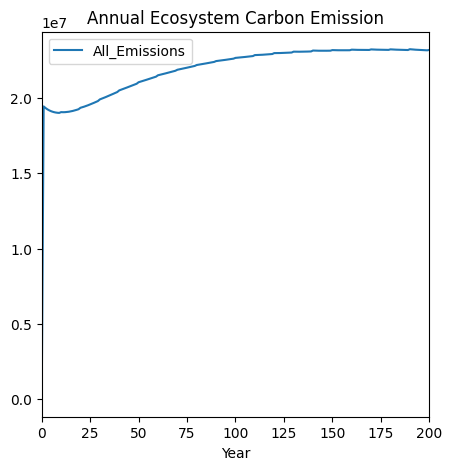

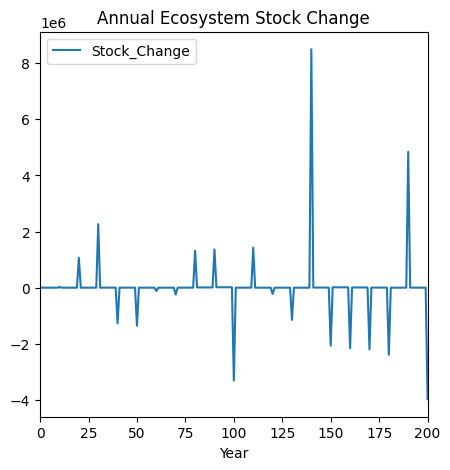

In [121]:
# Report Annual CBM Outputs
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes)

(    period  biomass_stock     dom_stock     eco_stock  stock_change  \
 0        1   4.779805e+08  9.575772e+08  1.422930e+09  0.000000e+00   
 1        2   5.113865e+08  9.432192e+08  1.442971e+09  2.004121e+07   
 2        3   5.474821e+08  9.402385e+08  1.477181e+09  3.420994e+07   
 3        4   5.844599e+08  9.432459e+08  1.518425e+09  4.124433e+07   
 4        5   6.197090e+08  9.494170e+08  1.561301e+09  4.287531e+07   
 5        6   6.509031e+08  9.569819e+08  1.601427e+09  4.012638e+07   
 6        7   6.776297e+08  9.647694e+08  1.637398e+09  3.597052e+07   
 7        8   6.987183e+08  9.726970e+08  1.668056e+09  3.065827e+07   
 8        9   7.148526e+08  9.804340e+08  1.693560e+09  2.550362e+07   
 9       10   7.268075e+08  9.878087e+08  1.714352e+09  2.079197e+07   
 10      11   7.348212e+08  9.950825e+08  1.730813e+09  1.646125e+07   
 11      12   7.406022e+08  1.001614e+09  1.743925e+09  1.311231e+07   
 12      13   7.448602e+08  1.007488e+09  1.754455e+09  1.052944

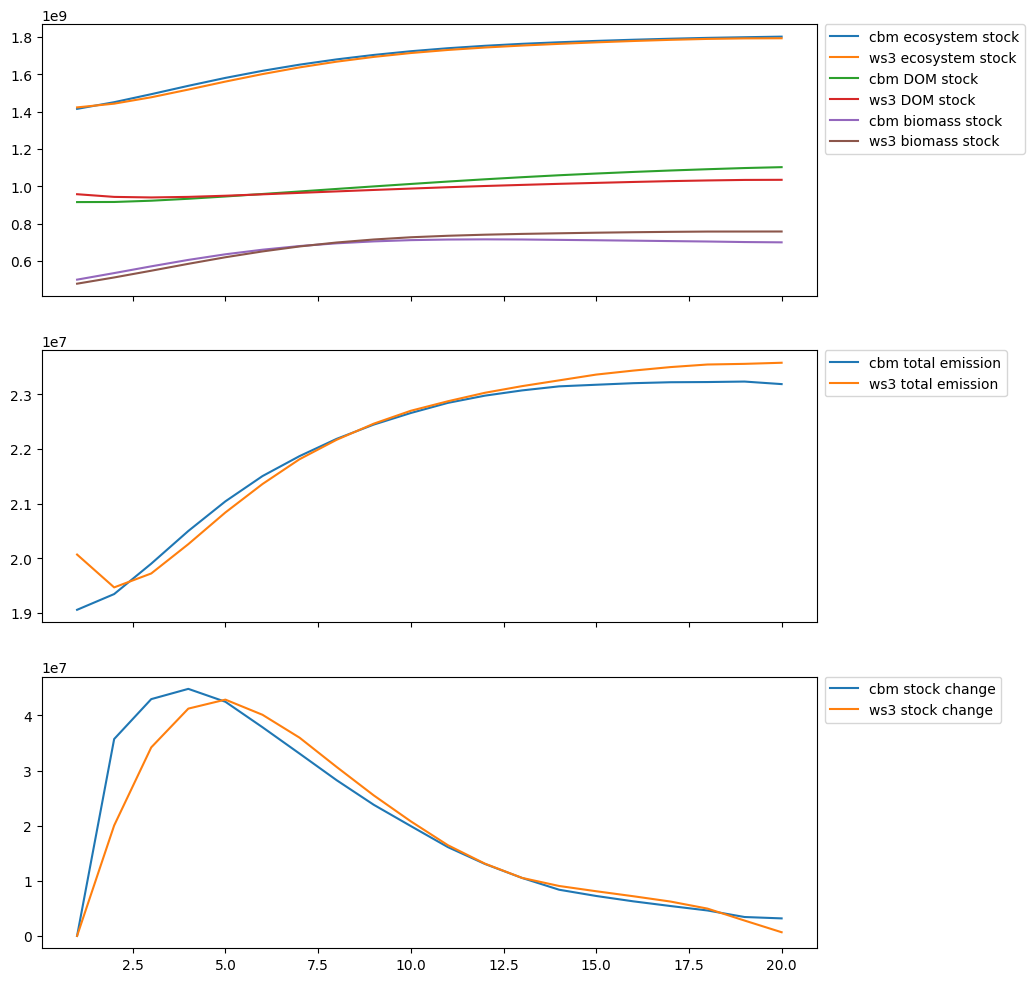

In [122]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, fluxes)

In [123]:
print('It took ', round((time.time()-Start)/60, 1), " minutes to run this script.")

It took  19.9  minutes to run this script.


## Minimize Total Carbon Emissions without Any Constrations

There will be the least harvesting activities if the target is to maxmize the total ecosystem carbon stock

running base scenario with even-flow constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 810 rows, 45499 columns and 486195 nonzeros
Model fingerprint: 0x29cd0c81
Coefficient statistics:
  Matrix range     [2e-01, 1e+05]
  Objective range  [9e+01, 1e+07]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 332 rows and 330 columns
Presolve time: 0.24s
Presolved: 478 rows, 45169 columns, 470823 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.669e+04
 Factor NZ  : 2.218e+04 (roughly 20 MB of memory)
 Factor Ops : 1.107e+06 (less than 1 second per iteration)
 Threads    : 14

                  Objective                Residual
Iter      

(<Figure size 1200x400 with 5 Axes>,
     period            oha           ohv           ogs           ocp  \
 0        1  485903.370370  1.032232e+08  6.279657e+08  1.347937e+09   
 1        2  510198.538889  9.810265e+07  5.752652e+08  1.314169e+09   
 2        3  470315.881481  8.289914e+07  5.490015e+08  1.289089e+09   
 3        4  461608.201852  1.142460e+08  4.943980e+08  1.268622e+09   
 4        5  461608.201852  6.560570e+07  4.991441e+08  1.248414e+09   
 5        6  461608.201852  8.751799e+07  4.754949e+08  1.241980e+09   
 6        7  461608.201852  9.387271e+07  4.317052e+08  1.231875e+09   
 7        8  461608.201852  9.196584e+07  3.808244e+08  1.219311e+09   
 8        9  510198.538889  6.514337e+07  3.647428e+08  1.219071e+09   
 9       10  510198.538889  3.563825e+07  3.812378e+08  1.223842e+09   
 10      11  510198.538889  2.902545e+07  4.096632e+08  1.233705e+09   
 11      12  510198.538889  8.852572e+07  3.801681e+08  1.236087e+09   
 12      13  510198.538889 

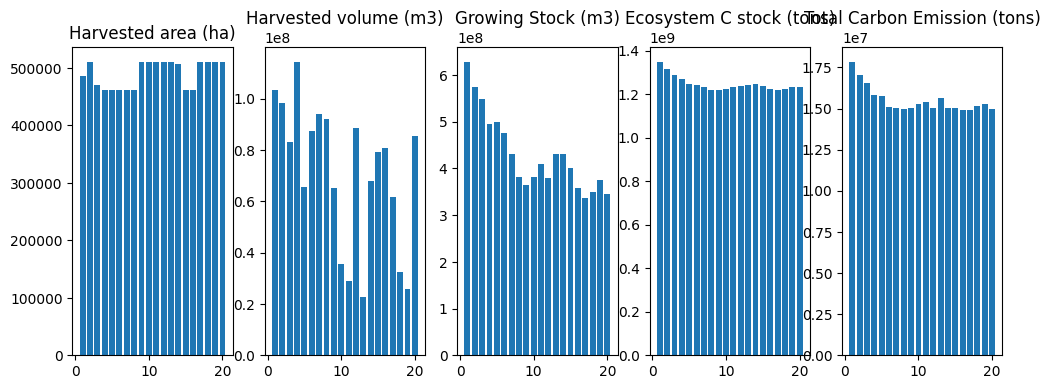

In [128]:
# Minimize Total Carbon Emissions
run_scenario(fm,'base_c')

In [129]:
#Generate New Sit_events file
sit_events = complie_events(fm, softwood_volume_yname, hardwood_volume_yname, n_yield_vals)

In [130]:
# Replace the Sit_events file in the sit tables
sit_tables['sit_events'] = sit_events

In [131]:
# Run CBM and Generate CBM Ouputs
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

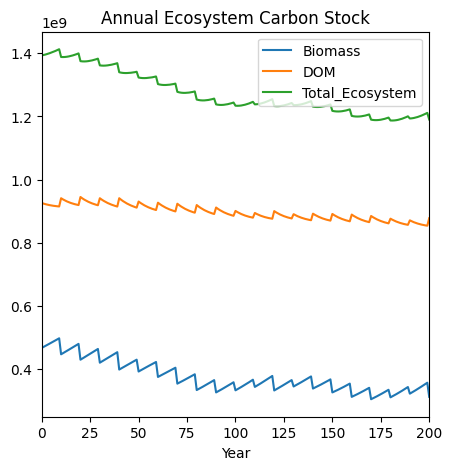

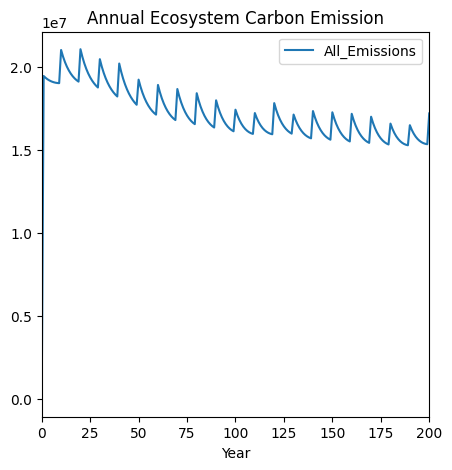

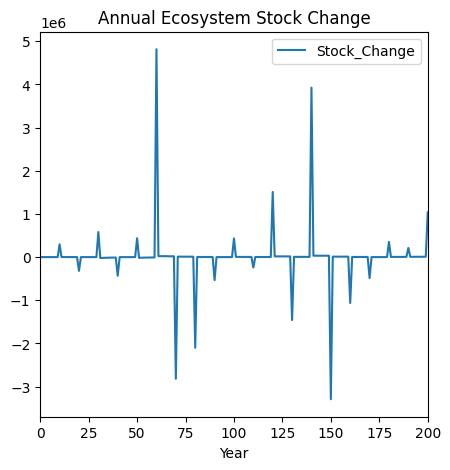

In [132]:
# Report Annual CBM Outputs
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes)

(    period  biomass_stock     dom_stock     eco_stock  stock_change  \
 0        1   4.111245e+08  9.492049e+08  1.347937e+09  0.000000e+00   
 1        2   3.918026e+08  9.330976e+08  1.314169e+09 -3.376762e+07   
 2        3   3.818234e+08  9.159057e+08  1.289089e+09 -2.507987e+07   
 3        4   3.623771e+08  9.133215e+08  1.268622e+09 -2.046725e+07   
 4        5   3.606083e+08  8.914889e+08  1.248414e+09 -2.020805e+07   
 5        6   3.510274e+08  8.930993e+08  1.241980e+09 -6.433781e+06   
 6        7   3.382874e+08  8.961670e+08  1.231875e+09 -1.010484e+07   
 7        8   3.237071e+08  8.973117e+08  1.219311e+09 -1.256404e+07   
 8        9   3.199598e+08  9.008280e+08  1.219071e+09 -2.408084e+05   
 9       10   3.274327e+08  8.983347e+08  1.223842e+09  4.771434e+06   
 10      11   3.391229e+08  8.967513e+08  1.233705e+09  9.862812e+06   
 11      12   3.292315e+08  9.081862e+08  1.236087e+09  2.382315e+06   
 12      13   3.438105e+08  9.015186e+08  1.243466e+09  7.378912

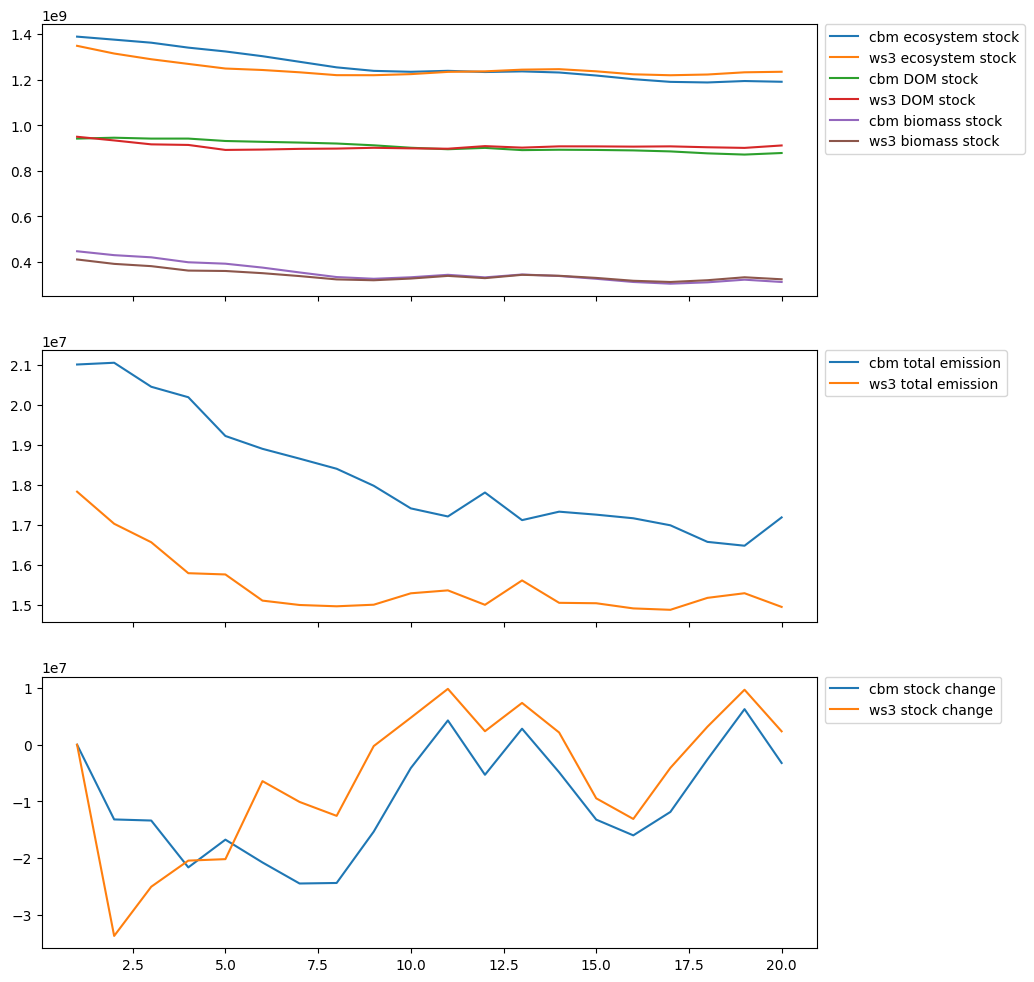

In [133]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, fluxes)

In [134]:
print('It took ', round((time.time()-Start)/60, 1), " minutes to run this script.")

It took  22.0  minutes to run this script.


## Minimize Total Carbon Emissions with Harvesting and Growing Stock Constraints

running base scenario with even-flow constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 814 rows, 45499 columns and 557773 nonzeros
Model fingerprint: 0xe633afde
Coefficient statistics:
  Matrix range     [2e-01, 5e+07]
  Objective range  [9e+01, 1e+07]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 334 rows and 330 columns
Presolve time: 0.32s
Presolved: 480 rows, 45171 columns, 506284 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.753e+04
 Factor NZ  : 2.306e+04 (roughly 20 MB of memory)
 Factor Ops : 1.195e+06 (less t

(<Figure size 1200x400 with 5 Axes>,
     period            oha           ohv           ogs           ocp  \
 0        1  171778.373919  1.406393e+07  7.328590e+08  1.379440e+09   
 1        2  180367.292615  3.828937e+07  7.481564e+08  1.378457e+09   
 2        3  180367.292615  3.248327e+07  7.810367e+08  1.387259e+09   
 3        4  180367.292615  3.530116e+07  8.219054e+08  1.402614e+09   
 4        5  180367.292615  3.460900e+07  8.690221e+08  1.419863e+09   
 5        6  180367.292615  3.708720e+07  9.092190e+08  1.434105e+09   
 6        7  180367.292615  3.667749e+07  9.393805e+08  1.444099e+09   
 7        8  180367.292615  3.633316e+07  9.591984e+08  1.451186e+09   
 8        9  180367.292615  4.461891e+07  9.583779e+08  1.452897e+09   
 9       10  180367.292615  4.503026e+07  9.498876e+08  1.452223e+09   
 10      11  180367.292615  4.970879e+07  9.314999e+08  1.450478e+09   
 11      12  180367.292615  4.808575e+07  9.135536e+08  1.450131e+09   
 12      13  180367.292615 

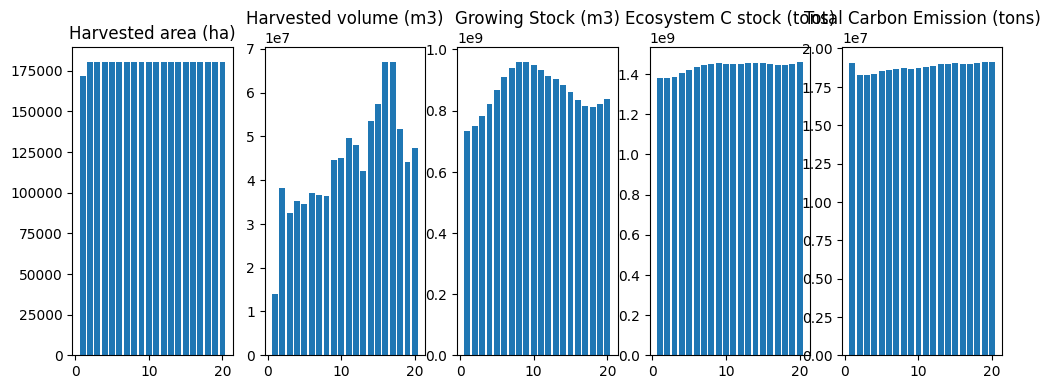

In [118]:
run_scenario(fm,'base_c')

In [119]:
#Generate New Sit_events file
sit_events = complie_events(fm, softwood_volume_yname, hardwood_volume_yname, n_yield_vals)

In [120]:
# Replace the Sit_events file in the sit tables
sit_tables['sit_events'] = sit_events

In [121]:
sit_events

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,min_softwood_age,max_softwood_age,min_hardwood_age,...,MinSWMerchStemSnagC,MaxSWMerchStemSnagC,MinHWMerchStemSnagC,MaxHWMerchStemSnagC,efficiency,sort_type,target_type,target,disturbance_type,disturbance_year
0,tsa24,1,2401002,204,2401002,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,65921.600000,harvest,10
1,tsa24,1,2401002,204,2401002,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,34536.873919,harvest,10
2,tsa24,1,2401007,100,2401007,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,3792.000000,harvest,10
3,tsa24,1,2402003,304,2402003,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,6581.500000,harvest,10
4,tsa24,1,2402004,104,2402004,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,1034.600000,harvest,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,tsa24,1,2403007,100,2403007,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,138.900000,harvest,200
372,tsa24,1,2403007,100,2403007,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,30.200000,harvest,200
373,tsa24,1,2403007,100,2403007,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,93.700000,harvest,200
374,tsa24,1,2403007,100,2423007,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,18459.400000,harvest,200


In [122]:
# Run CBM and Generate CBM Ouputs
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

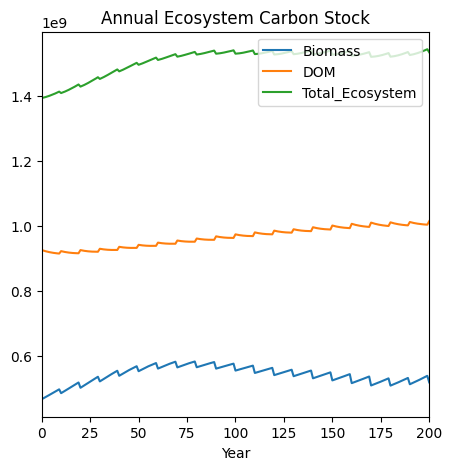

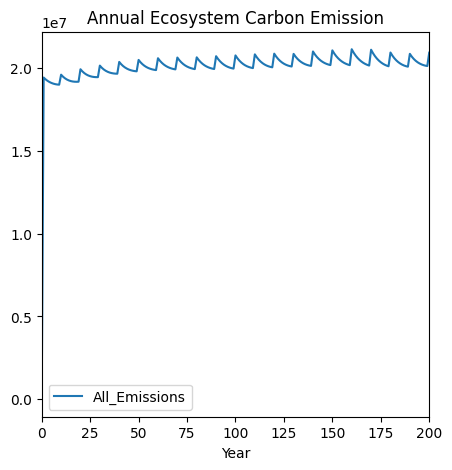

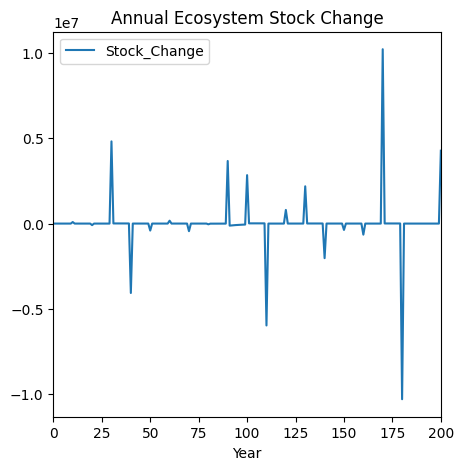

In [123]:
# Report Annual CBM Outputs
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes)

(    period  biomass_stock     dom_stock     eco_stock  stock_change  \
 0        1   4.549067e+08  9.361385e+08  1.379440e+09  0.000000e+00   
 1        2   4.674013e+08  9.216810e+08  1.378457e+09 -9.831368e+05   
 2        3   4.850040e+08  9.120243e+08  1.387259e+09  8.802515e+06   
 3        4   5.030194e+08  9.081597e+08  1.402614e+09  1.535499e+07   
 4        5   5.201751e+08  9.066792e+08  1.419863e+09  1.724844e+07   
 5        6   5.335438e+08  9.064204e+08  1.434105e+09  1.424231e+07   
 6        7   5.426542e+08  9.056354e+08  1.444099e+09  9.993968e+06   
 7        8   5.485350e+08  9.052107e+08  1.451186e+09  7.087376e+06   
 8        9   5.472549e+08  9.069736e+08  1.452897e+09  1.710560e+06   
 9       10   5.448813e+08  9.079479e+08  1.452223e+09 -6.739892e+05   
 10      11   5.409607e+08  9.094952e+08  1.450478e+09 -1.744745e+06   
 11      12   5.383456e+08  9.116491e+08  1.450131e+09 -3.467971e+05   
 12      13   5.385881e+08  9.138878e+08  1.452816e+09  2.684509

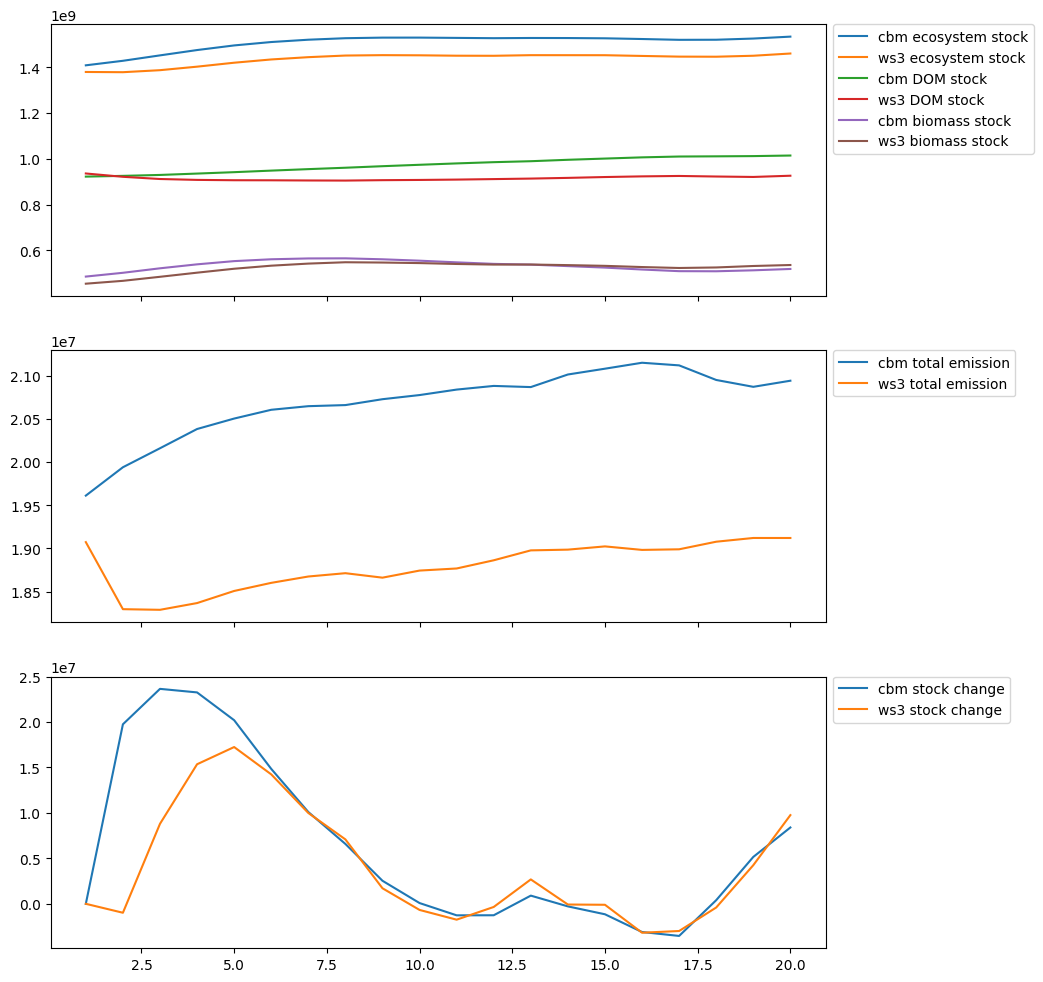

In [124]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, fluxes)

In [125]:
print('It took ', round((time.time()-Start)/60, 1), " minutes to run this script.")

It took  19.6  minutes to run this script.


## Maximize Total Ecosystem Carbon Sequestration without Constraints

running base scenario with even-flow constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 814 rows, 45499 columns and 557773 nonzeros
Model fingerprint: 0x28066f0e
Coefficient statistics:
  Matrix range     [2e-01, 5e+07]
  Objective range  [1e+02, 1e+07]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 334 rows and 330 columns
Presolve time: 0.27s
Presolved: 480 rows, 45171 columns, 506284 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.753e+04
 Factor NZ  : 2.306e+04 (roughly 20 MB of memory)
 Factor Ops : 1.195e+06 (less t

(<Figure size 1200x400 with 5 Axes>,
     period           oha           ohv           ogs           ocp  \
 0        1  10702.042766  3.515982e+06  7.452683e+08  1.422930e+09   
 1        2  10166.940628  2.254932e+06  8.056441e+08  1.442971e+09   
 2        3  10166.940628  2.556618e+06  8.760518e+08  1.477181e+09   
 3        4  10166.940628  2.919244e+06  9.567992e+08  1.518425e+09   
 4        5  10166.940628  3.148669e+06  1.042853e+09  1.561301e+09   
 5        6  10166.940628  3.201031e+06  1.125348e+09  1.601427e+09   
 6        7  10166.940628  5.098721e+05  1.199864e+09  1.637398e+09   
 7        8  10166.940628  5.098721e+05  1.260175e+09  1.668056e+09   
 8        9  10166.940628  5.098721e+05  1.306643e+09  1.693560e+09   
 9       10  10166.940628  8.623821e+05  1.340643e+09  1.714352e+09   
 10      11  10166.940628  2.847161e+06  1.362259e+09  1.730813e+09   
 11      12  10166.940628  2.635264e+06  1.375866e+09  1.743925e+09   
 12      13  10166.940628  2.425255e+06 

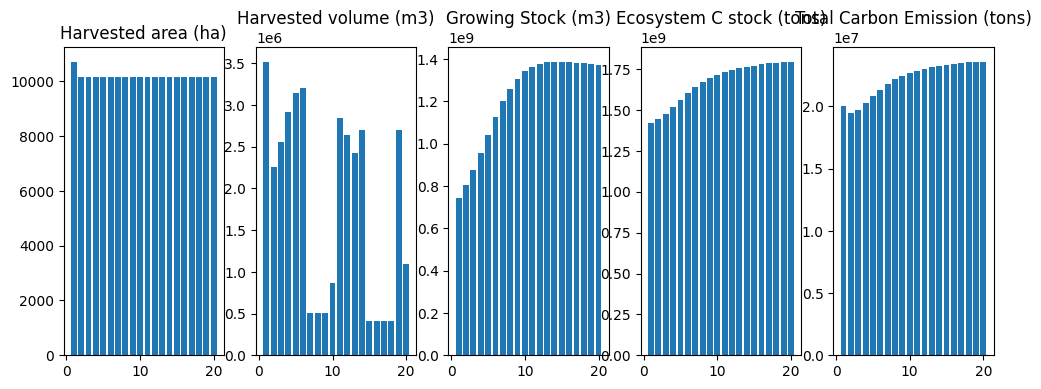

In [104]:
# Maxmize Total Ecosystem Carbon Sequestration with Havrest and Growing Stock Constraints
run_scenario(fm,'base_c')

In [105]:
#Generate New Sit_events file
sit_events = complie_events(fm, softwood_volume_yname, hardwood_volume_yname, n_yield_vals)

In [106]:
# Replace the Sit_events file in the sit tables
sit_tables['sit_events'] = sit_events

In [107]:
# Run CBM and Generate CBM Ouputs
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

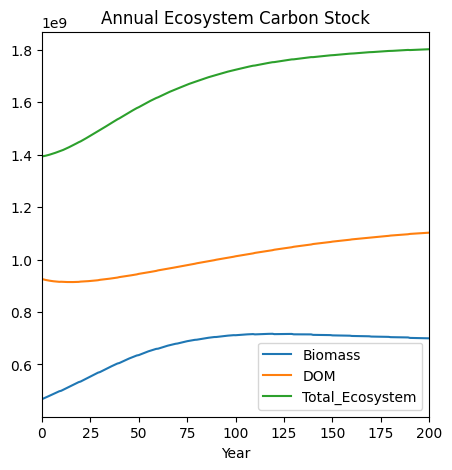

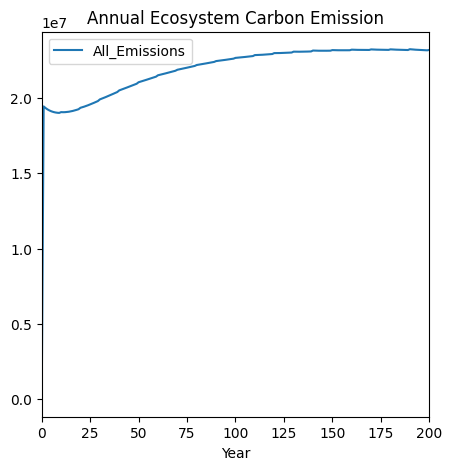

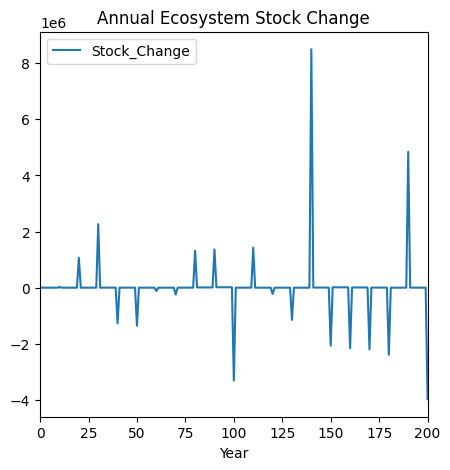

In [108]:
# Report Annual CBM Outputs
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes)

(    period  biomass_stock     dom_stock     eco_stock  stock_change  \
 0        1   4.779805e+08  9.575772e+08  1.422930e+09  0.000000e+00   
 1        2   5.113865e+08  9.432192e+08  1.442971e+09  2.004121e+07   
 2        3   5.474821e+08  9.402385e+08  1.477181e+09  3.420994e+07   
 3        4   5.844599e+08  9.432459e+08  1.518425e+09  4.124433e+07   
 4        5   6.197090e+08  9.494170e+08  1.561301e+09  4.287531e+07   
 5        6   6.509031e+08  9.569819e+08  1.601427e+09  4.012638e+07   
 6        7   6.776297e+08  9.647694e+08  1.637398e+09  3.597052e+07   
 7        8   6.987183e+08  9.726970e+08  1.668056e+09  3.065827e+07   
 8        9   7.148526e+08  9.804340e+08  1.693560e+09  2.550362e+07   
 9       10   7.268075e+08  9.878087e+08  1.714352e+09  2.079197e+07   
 10      11   7.348212e+08  9.950825e+08  1.730813e+09  1.646125e+07   
 11      12   7.406022e+08  1.001614e+09  1.743925e+09  1.311231e+07   
 12      13   7.448602e+08  1.007488e+09  1.754455e+09  1.052944

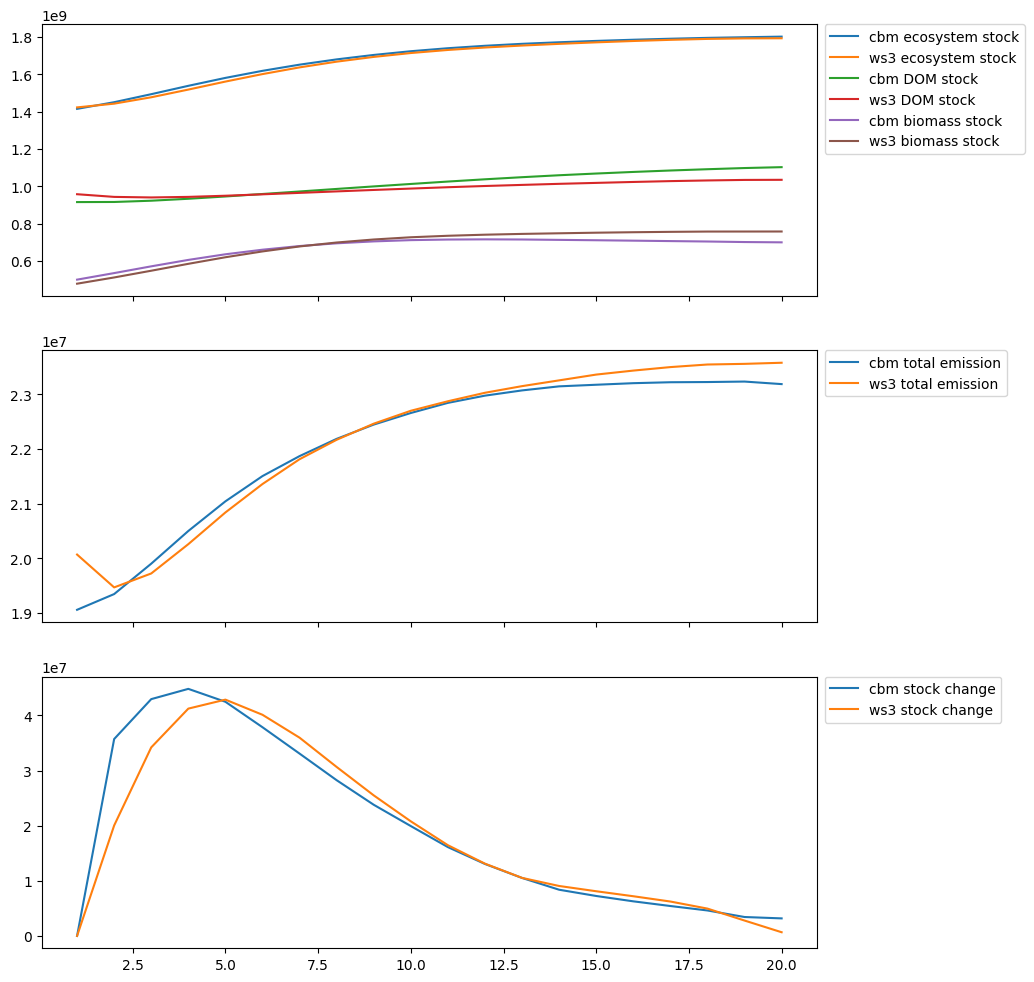

In [109]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, fluxes)

In [110]:
print('It took ', round((time.time()-Start)/60, 1), " minutes to run this script.")

It took  17.1  minutes to run this script.


## Maximize Total Ecosystem Carbon Sequestration with Harvesting and Growing Stock Constraints

running base scenario with even-flow constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 814 rows, 45499 columns and 557773 nonzeros
Model fingerprint: 0x28066f0e
Coefficient statistics:
  Matrix range     [2e-01, 5e+07]
  Objective range  [1e+02, 1e+07]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 334 rows and 330 columns
Presolve time: 0.27s
Presolved: 480 rows, 45171 columns, 506284 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier performed 0 iterations in 0.49 seconds (0.19 work units)
Barrier solve interrupted - model solved by another algorith

(<Figure size 1200x400 with 5 Axes>,
     period           oha           ohv           ogs           ocp  \
 0        1  10702.042766  3.515982e+06  7.452683e+08  1.422930e+09   
 1        2  10166.940628  2.254932e+06  8.056441e+08  1.442971e+09   
 2        3  10166.940628  2.556618e+06  8.760518e+08  1.477181e+09   
 3        4  10166.940628  2.919244e+06  9.567992e+08  1.518425e+09   
 4        5  10166.940628  3.148669e+06  1.042853e+09  1.561301e+09   
 5        6  10166.940628  3.201031e+06  1.125348e+09  1.601427e+09   
 6        7  10166.940628  5.098721e+05  1.199864e+09  1.637398e+09   
 7        8  10166.940628  5.098721e+05  1.260175e+09  1.668056e+09   
 8        9  10166.940628  5.098721e+05  1.306643e+09  1.693560e+09   
 9       10  10166.940628  8.623821e+05  1.340643e+09  1.714352e+09   
 10      11  10166.940628  2.847161e+06  1.362259e+09  1.730813e+09   
 11      12  10166.940628  2.635264e+06  1.375866e+09  1.743925e+09   
 12      13  10166.940628  2.425255e+06 

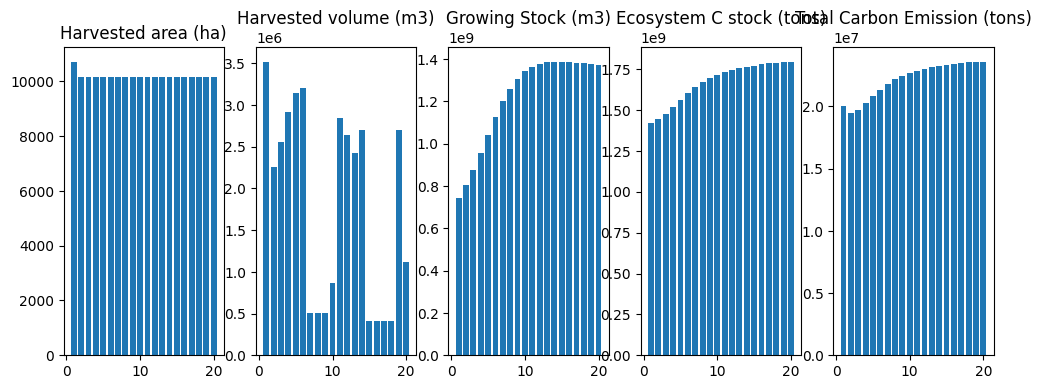

In [111]:
# Maxmize Total Ecosystem Carbon Sequestration with Havrest and Growing Stock Constraints
run_scenario(fm,'base_c')

In [112]:
#Generate New Sit_events file
sit_events = complie_events(fm, softwood_volume_yname, hardwood_volume_yname, n_yield_vals)

In [113]:
# Replace the Sit_events file in the sit tables
sit_tables['sit_events'] = sit_events

In [114]:
# Run CBM and Generate CBM Ouputs
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

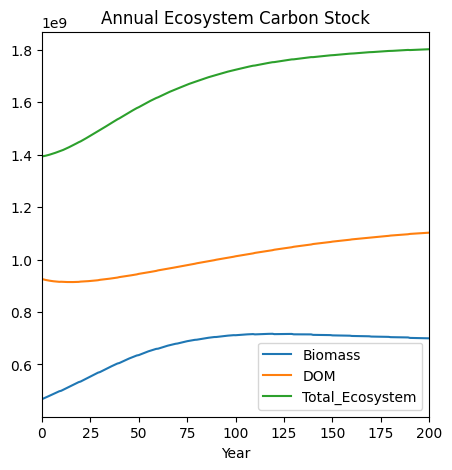

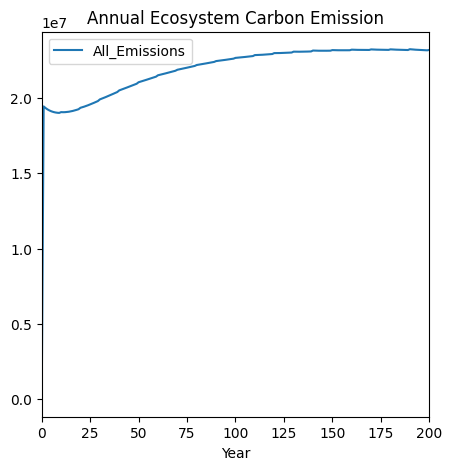

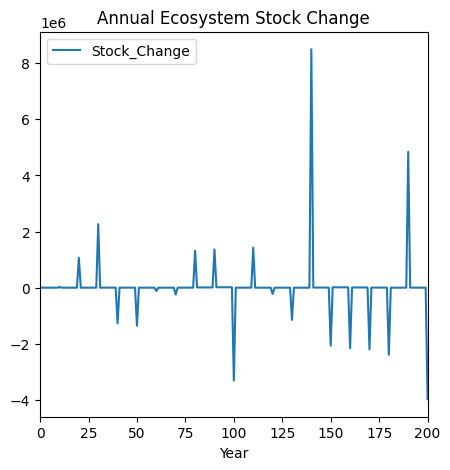

In [115]:
# Report Annual CBM Outputs
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes)

(    period  biomass_stock     dom_stock     eco_stock  stock_change  \
 0        1   4.779805e+08  9.575772e+08  1.422930e+09  0.000000e+00   
 1        2   5.113865e+08  9.432192e+08  1.442971e+09  2.004121e+07   
 2        3   5.474821e+08  9.402385e+08  1.477181e+09  3.420994e+07   
 3        4   5.844599e+08  9.432459e+08  1.518425e+09  4.124433e+07   
 4        5   6.197090e+08  9.494170e+08  1.561301e+09  4.287531e+07   
 5        6   6.509031e+08  9.569819e+08  1.601427e+09  4.012638e+07   
 6        7   6.776297e+08  9.647694e+08  1.637398e+09  3.597052e+07   
 7        8   6.987183e+08  9.726970e+08  1.668056e+09  3.065827e+07   
 8        9   7.148526e+08  9.804340e+08  1.693560e+09  2.550362e+07   
 9       10   7.268075e+08  9.878087e+08  1.714352e+09  2.079197e+07   
 10      11   7.348212e+08  9.950825e+08  1.730813e+09  1.646125e+07   
 11      12   7.406022e+08  1.001614e+09  1.743925e+09  1.311231e+07   
 12      13   7.448602e+08  1.007488e+09  1.754455e+09  1.052944

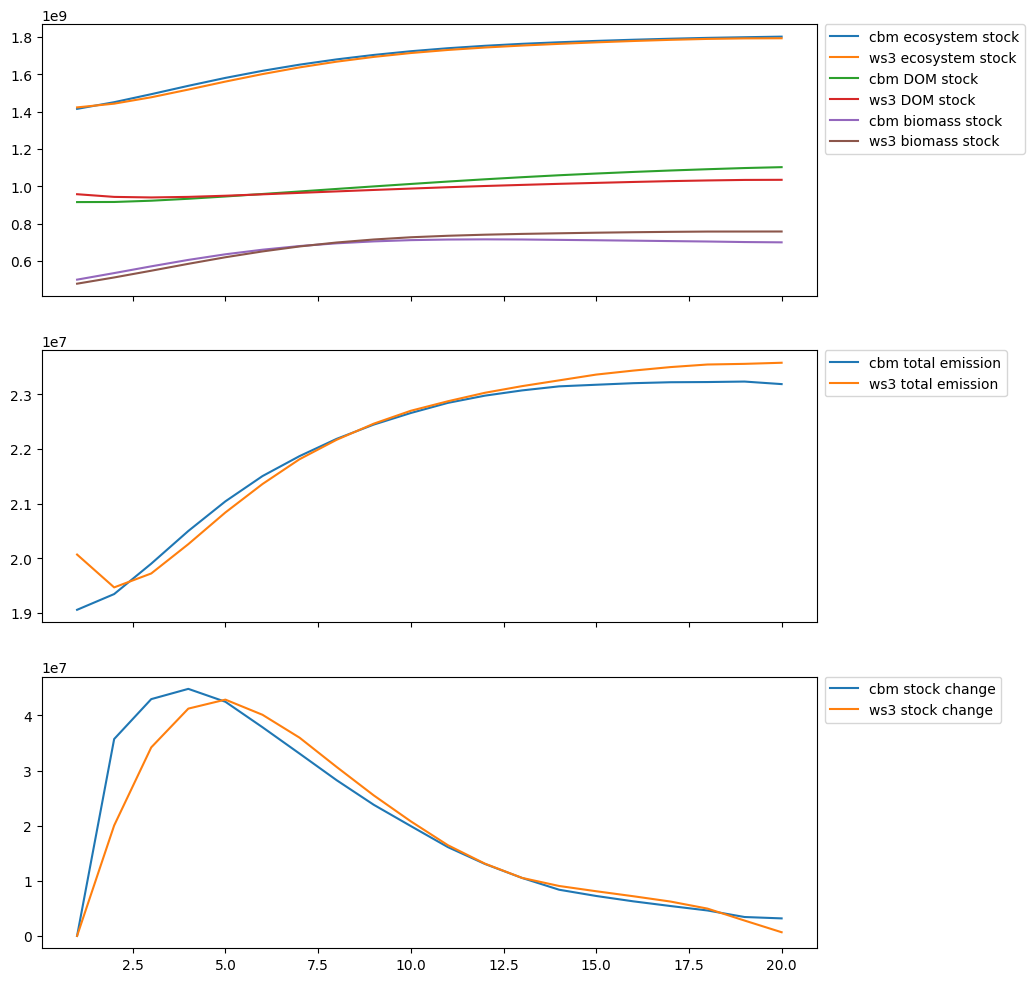

In [116]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, fluxes)